## Predicting Problem Mortgage Loans
By: Magali Solimano  
Date: December 2022

## Overview

This analysis applies machine learning to predict the likelihood that a borrower will have problems paying  
its mortgage loan. The goal is to identify problem loans and the features that determine them in order to  
manage credit risk. While mortgage loan delinquencies are currently [very low](https://www.newyorkfed.org/microeconomics/hhdc), the value-added use case of  
the machine learning model would strengthen credit risk management in the current environment as well  
as during stress periods. 

Data is obtained from [Fannie Mae's Single Family Loan Data](https://capitalmarkets.fanniemae.com/credit-risk-transfer/single-family-credit-risk-transfer/fannie-mae-single-family-loan-performance-data), which is publically available and provides a  
subset of acquisition and performance data through Q2 2022 as of December 2022. This notebook focuses  
on loans acquired by Fannie Mae in Q1 2021, a quarter of high activity in the single family residential market,  
and tracks 15 months of performance.

Problem loans are defined as loans with payments that are 90 or more days past due; loans that have been  
modified, restructured, or received any borrower assistance; and loans that have been foreclosed. A binary  
variable, problem loans are classified as '1' and performing, non-problem loans as '0'.

## Import Libraries and Load Data


In [147]:
import pandas as pd
import numpy as np

# Data pre-processing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Data visualization
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as mtick

# Model building
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (plot_roc_curve, roc_curve, roc_auc_score, 
                             accuracy_score, precision_score, recall_score, 
                             f1_score, auc, average_precision_score, 
                             confusion_matrix, plot_confusion_matrix, 
                             ConfusionMatrixDisplay, classification_report,
                             precision_recall_curve)
from sklearn.linear_model import LogisticRegression
import six

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import data
data = pd.read_csv('Data/2021Q1.csv',sep="|", header=None)

In [4]:
# View shape of dataframe
data.shape

(23104273, 108)

- Dataset is very large, with 23 million rows and 108 columns.

In [5]:
# Define column names and rename columns
column_names = [
    'reference_pool_id',
    'loan_id',
    'monthly_reporting_pd',
    'channel',
    'seller_name',
    'servicer_name',
    'master_servicer',
    'origination_interest_rate',
    'current_interest_rate',
    'origination_UPB',
    'UPB_at_issuance',
    'current_actual_UPB',
    'origination_loan_term',
    'origination_date',
    'first_payment_date',
    'loan_age_months',
    'months_to_legal_maturity',
    'months_to_maturity',
    'maturity_date',
    'origination_ltv',
    'origination_combined_ltv',
    'number_of_borrowers',
    'debt_to_income',
    'borrower_credit_score_origination',
    'co-borrower_credit_score_origination',
    'first_time_homebuyer',
    'loan_purpose',
    'property_type',
    'number_of_units',
    'occupancy_status',
    'property_state',
    'metropolitan_statistical_area',
    'zipcode_short',
    'mortgage_insurance_pct',
    'amortization_type',
    'prepayment_penalty_indicator',
    'interest_only_loan_indicator',
    'interest_only_first_principal_int_payment_date',
    'months_to_amortization',
    'loan_delinquency_months',
    'loan_payment_history',
    'modification_flag',
    'mortgage_insurance_cancellation_indicator',
    'zero_balance_code',
    'zero_balance_effective_date',
    'upb_at_time_of_removal',
    'repurchase_date',
    'scheduled_principal_current',
    'total_principal_current',
    'unscheduled_principal_current',
    'last_paid_installment_date',
    'foreclosure_date',
    'disposition_date',
    'foreclosure_costs',
    'property_preservation_repair_costs',
    'asset_recovery_costs',
    'misc_holding_expenses_and_credits',
    'associated_taxes_for_holding_property',
    'net_sales_proceeds',
    'credit_enhancement_proceeds',
    'repurchase_make_whole_proceeds',
    'other_foreclosure_proceeds',
    'non_interest_bearing_upb',
    'principal_forgiveness_amount',
    'original_list_start_date',
    'original_list_price',
    'current_list_start_date',
    'current_list_price',
    'borrower_credit_score_origination',
    'co-borrower_credit_score_origination',
    'borrower_credit_score_current',
    'co-borrower_credit_score_current',
    'mortgage_insurance_type',
    'servicing_activity_indicator',
    'current_period_modification_loss_ammount',
    'cumulative_modification_loss_amount',
    'current_period_credit_event_net_gainloss',
    'cumulative_credit_event_net_gainloss',
    'special_eligibility_program',
    'foreclosure_principal_writeoff_amt',
    'relocation_mortgage_indicator',
    'zero_balance_code_change_date',
    'loan_holdback_indicator',
    'loan_holdback_effective_date',
    'delinquent_accrued_interest',
    'property_valuation_method',
    'high_balance_loan_indicator',
    'arm_initial_fixedrate_period_lessthan5yr_indicator',
    'arm_product_type',
    'initial_fixed_rate_period',
    'interest_rate_adj_frequency',
    'next_interest_rate_adj_date',
    'next_payment_change_date',
    'index',
    'arm_cap_structure',
    'initial_interest_rate_capup_pct',
    'periodic_interest_rate_capup_pct',
    'lifetime_interest_rate_capup_pct',
    'mortgage_margin',
    'arm_balloon_indicator',
    'arm_plan_number',
    'borrower_assistance_plan',
    'high_ltv_refinance_option_indicator',
    'deal_name',
    'repurchase_make_whole_proceeds_flag',
    'alternative_delinquency_resolution',
    'alternative_delinquency_resolution_count',
    'total_deferral_amount'] 

data.columns = column_names

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23104273 entries, 0 to 23104272
Columns: 108 entries, reference_pool_id to total_deferral_amount
dtypes: float64(75), int64(11), object(22)
memory usage: 18.6+ GB


- Several variables have dtypes that should be changed to string (zipcode and msa)  
and datetime (eg, date-related variable such as foreclosure date).

In [7]:
# View df with new column names
data.head()

,reference_pool_id,loan_id,monthly_reporting_pd,channel,seller_name,servicer_name,master_servicer,origination_interest_rate,current_interest_rate,origination_UPB,...,mortgage_margin,arm_balloon_indicator,arm_plan_number,borrower_assistance_plan,high_ltv_refinance_option_indicator,deal_name,repurchase_make_whole_proceeds_flag,alternative_delinquency_resolution,alternative_delinquency_resolution_count,total_deferral_amount
0,NaN,122128311,12021,R,"loanDepot.com, LLC","loanDepot.com, LLC",NaN,2.125,2.125,619000.0,...,NaN,NaN,NaN,7,N,NaN,NaN,7,NaN,NaN
1,NaN,122128311,22021,R,"loanDepot.com, LLC","loanDepot.com, LLC",NaN,2.125,2.125,619000.0,...,NaN,NaN,NaN,7,N,NaN,NaN,7,NaN,NaN
2,NaN,122128311,32021,R,"loanDepot.com, LLC","loanDepot.com, LLC",NaN,2.125,2.125,619000.0,...,NaN,NaN,NaN,7,N,NaN,NaN,7,NaN,NaN
3,NaN,122128311,42021,R,"loanDepot.com, LLC","loanDepot.com, LLC",NaN,2.125,2.125,619000.0,...,NaN,NaN,NaN,7,N,NaN,NaN,7,NaN,NaN
4,NaN,122128311,52021,R,"loanDepot.com, LLC","loanDepot.com, LLC",NaN,2.125,2.125,619000.0,...,NaN,NaN,NaN,7,N,NaN,NaN,7,NaN,NaN


In [8]:
# View df's descriptive statistics
data.describe()

,reference_pool_id,loan_id,monthly_reporting_pd,master_servicer,origination_interest_rate,current_interest_rate,origination_UPB,UPB_at_issuance,current_actual_UPB,origination_loan_term,...,arm_cap_structure,initial_interest_rate_capup_pct,periodic_interest_rate_capup_pct,lifetime_interest_rate_capup_pct,mortgage_margin,arm_balloon_indicator,arm_plan_number,deal_name,alternative_delinquency_resolution_count,total_deferral_amount
count,0.0,2.310427e+07,2.310427e+07,0.0,2.310427e+07,2.297653e+07,2.310427e+07,0.0,2.310427e+07,2.310427e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13096.000000,13096.000000
mean,NaN,1.228179e+08,5.968742e+04,NaN,2.787136e+00,2.786576e+00,2.822724e+05,NaN,2.736624e+05,3.147012e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.019166,9074.492603
std,NaN,4.080091e+05,3.227374e+04,NaN,3.585050e-01,3.581182e-01,1.451962e+05,NaN,1.441662e+05,7.629344e+01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.145753,7804.493354
min,NaN,1.221283e+08,1.202100e+04,NaN,1.500000e+00,1.500000e+00,1.500000e+04,NaN,0.000000e+00,8.500000e+01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,551.490000
25%,NaN,1.224628e+08,3.202200e+04,NaN,2.625000e+00,2.625000e+00,1.730000e+05,NaN,1.660000e+05,2.400000e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,3778.740000
50%,NaN,1.228084e+08,5.202200e+04,NaN,2.750000e+00,2.750000e+00,2.530000e+05,NaN,2.460000e+05,3.600000e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,6556.960000
75%,NaN,1.231696e+08,8.202100e+04,NaN,2.990000e+00,2.990000e+00,3.650000e+05,NaN,3.560000e+05,3.600000e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,11693.145000
max,NaN,1.235417e+08,1.220210e+05,NaN,5.875000e+00,5.875000e+00,1.582000e+06,NaN,1.582000e+06,3.600000e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,67940.680000


- Several columns have missing values to examine.

## Pre-processing Data

In [9]:
# Drop reference id, loan id, and date columns, which are not loan characteristics
# However, for now, keep foreclosure_date for feature engineering
# Drop metropolitan statistical area, since analylsis will work with state and zipcode

data.drop(['reference_pool_id', 'loan_id', 'monthly_reporting_pd', 
           'origination_date','first_payment_date', 'disposition_date',
           'maturity_date', 'loan_age_months', 
           'metropolitan_statistical_area'], axis = 1, 
           inplace = True)

### Change data types

In [10]:
# Convert foreclosure_date column to datetime with format mm/dd/yy
data['foreclosure_date'] = pd.to_datetime(data['foreclosure_date'], format='%m%d%y')
# Convert zipcode_short to string
data['zipcode_short'] = data['zipcode_short'].astype(str)

### Null values

In [11]:
# Drop columns that have all NaNs
data = data.dropna(how='all', axis=1)
data.head()

,channel,seller_name,servicer_name,origination_interest_rate,current_interest_rate,origination_UPB,current_actual_UPB,origination_loan_term,months_to_legal_maturity,months_to_maturity,...,foreclosure_principal_writeoff_amt,relocation_mortgage_indicator,property_valuation_method,high_balance_loan_indicator,borrower_assistance_plan,high_ltv_refinance_option_indicator,repurchase_make_whole_proceeds_flag,alternative_delinquency_resolution,alternative_delinquency_resolution_count,total_deferral_amount
0,R,"loanDepot.com, LLC","loanDepot.com, LLC",2.125,2.125,619000.0,616000.0,180,180.0,179.0,...,NaN,N,W,Y,7,N,NaN,7,NaN,NaN
1,R,"loanDepot.com, LLC","loanDepot.com, LLC",2.125,2.125,619000.0,613000.0,180,179.0,178.0,...,NaN,N,W,Y,7,N,NaN,7,NaN,NaN
2,R,"loanDepot.com, LLC","loanDepot.com, LLC",2.125,2.125,619000.0,610000.0,180,178.0,177.0,...,NaN,N,W,Y,7,N,NaN,7,NaN,NaN
3,R,"loanDepot.com, LLC","loanDepot.com, LLC",2.125,2.125,619000.0,607000.0,180,177.0,176.0,...,NaN,N,W,Y,7,N,NaN,7,NaN,NaN
4,R,"loanDepot.com, LLC","loanDepot.com, LLC",2.125,2.125,619000.0,604000.0,180,176.0,175.0,...,NaN,N,W,Y,7,N,NaN,7,NaN,NaN


In [12]:
# Check for null values
print(data.isnull().sum())

channel                                            0
seller_name                                        0
servicer_name                                 127751
origination_interest_rate                          0
current_interest_rate                         127741
origination_UPB                                    0
current_actual_UPB                                 0
origination_loan_term                              0
months_to_legal_maturity                      127751
months_to_maturity                            127902
origination_ltv                                    0
origination_combined_ltv                           0
number_of_borrowers                                0
debt_to_income                                   558
borrower_credit_score_origination               6380
co-borrower_credit_score_origination        12212372
first_time_homebuyer                               0
loan_purpose                                       0
property_type                                 

- Several columns still have a significant amount of missing data. Based on the similar counts of missing  
data, it appears that there are records that have missing values for several columns.

In [13]:
# Examine mortgage insurance type, which has high number of null values
data['mortgage_insurance_type'].value_counts(dropna=False)

NaN    18999872
1.0     4050099
2.0       43908
3.0       10394
Name: mortgage_insurance_type, dtype: int64

In [14]:
# For mortgage_insurance_type, fill NaN with '4' to represent 'no mortgage insurance'
data['mortgage_insurance_type'].fillna('4', inplace=True)
data['mortgage_insurance_type'].replace({1.0: 1, 2.0: 2, 3.0: 3}, inplace=True)
# View value counts
data['mortgage_insurance_type'].value_counts()

4    18999872
1     4050099
2       43908
3       10394
Name: mortgage_insurance_type, dtype: int64

In [15]:
# Examine co-borrower credit scores, which has high number of null values, 
# possibly indicating that there is no co-borrower
data['co-borrower_credit_score_origination'].value_counts(dropna = False)

NaN      12212372
809.0      226704
801.0      224981
808.0      197816
804.0      182465
           ...   
839.0          71
833.0          34
840.0          18
841.0          17
835.0          16
Name: co-borrower_credit_score_origination, Length: 220, dtype: int64

In [16]:
data['co-borrower_credit_score_origination'].mean()

771.3581163655454

In [17]:
# Examine principal forgiveness amount and foreclosure principal write-off amount
print(data['principal_forgiveness_amount'].value_counts(dropna = False))
print('-----'*10)
print(data['foreclosure_principal_writeoff_amt'].value_counts(dropna=False))

NaN    23090902
0.0       13371
Name: principal_forgiveness_amount, dtype: int64
--------------------------------------------------
NaN    23090902
0.0       13371
Name: foreclosure_principal_writeoff_amt, dtype: int64


In [18]:
print(data['principal_forgiveness_amount'].nunique())
print(data['foreclosure_principal_writeoff_amt'].nunique())

1
1


- principal forgiveness amount and foreclosure principal writeoff amount variables do not appear to  
provide information on amounts, but rather appear to be a binary classification that is not labelled correctly
- Each variable only has 1 unique value, which is 0
- Variables also represent future information that will not assist with predicting problem loans

In [19]:
data['alternative_delinquency_resolution_count'].value_counts(dropna=False)

NaN    23091177
1.0       12860
2.0         222
3.0          13
4.0           1
Name: alternative_delinquency_resolution_count, dtype: int64

- Most records do not have alternative delinquency resolutions, since most loan  
payments are not late nor delinquent.

In [20]:
# Fill NA with 0 for alternative delinquency resolution count 
data['alternative_delinquency_resolution_count'].fillna(0, inplace=True)
data['alternative_delinquency_resolution_count'].value_counts(dropna=False)

0.0    23091177
1.0       12860
2.0         222
3.0          13
4.0           1
Name: alternative_delinquency_resolution_count, dtype: int64

In [21]:
# Calculate mean deferral amount for loans that do require alternative delinquency resolution
data['total_deferral_amount'].mean()

9074.492603084916

In [22]:
# Drop columns where more than 50% of values are missing
# Keep foreclosure date for later use in calculation of problem loans 
data.drop(['co-borrower_credit_score_origination', 'mortgage_insurance_pct',
          'zero_balance_code', 'zero_balance_effective_date',
          'upb_at_time_of_removal', 'last_paid_installment_date',
          'total_principal_current', 
           'non_interest_bearing_upb', 'principal_forgiveness_amount',
           'foreclosure_principal_writeoff_amt', 
          'repurchase_make_whole_proceeds_flag',  
          'total_deferral_amount'], axis = 1, inplace=True)

In [23]:
data.isnull().sum()

channel                                            0
seller_name                                        0
servicer_name                                 127751
origination_interest_rate                          0
current_interest_rate                         127741
origination_UPB                                    0
current_actual_UPB                                 0
origination_loan_term                              0
months_to_legal_maturity                      127751
months_to_maturity                            127902
origination_ltv                                    0
origination_combined_ltv                           0
number_of_borrowers                                0
debt_to_income                                   558
borrower_credit_score_origination               6380
first_time_homebuyer                               0
loan_purpose                                       0
property_type                                      0
number_of_units                               

In [24]:
# Fill NA with mean for variables: debt_to_income, borrower_credit_score_origination, 
# months_to_maturity
data['debt_to_income'].fillna(data['debt_to_income'].mean(), inplace=True)
data['borrower_credit_score_origination'].fillna(
    data['borrower_credit_score_origination'].mean(), inplace=True)
data['months_to_maturity'].fillna(data['months_to_maturity'].mean(), inplace=True)

In [25]:
data['foreclosure_date'].value_counts(dropna=False)

NaT           23104263
2022-05-20           2
2021-12-20           2
2022-06-20           1
2021-06-20           1
2022-04-20           1
2022-01-20           1
2022-03-20           1
2022-02-20           1
Name: foreclosure_date, dtype: int64

- Only a handfull of records have foreclosed

In [26]:
# instantiate label encoder
label_enc = LabelEncoder()

In [27]:
# Create new, binary variable that indicates foreclosure status (0: no, 1: yes)
data['foreclosure_status'] = np.where(data['foreclosure_date'].isnull(), 0, 1)
# Apply label encoding
data['foreclosure_status'] = label_enc.fit_transform(data['foreclosure_status'].astype(str))
data['foreclosure_status'].value_counts(dropna=False)

0    23104263
1          10
Name: foreclosure_status, dtype: int64

In [28]:
# Drop foreclosure date, which has mostly missing values
data.drop(['foreclosure_date'], axis=1, inplace=True)

In [29]:
# Examine missing values for servicer_name variable
data[data['servicer_name'].isna()]

,channel,seller_name,servicer_name,origination_interest_rate,current_interest_rate,origination_UPB,current_actual_UPB,origination_loan_term,months_to_legal_maturity,months_to_maturity,...,servicing_activity_indicator,special_eligibility_program,relocation_mortgage_indicator,property_valuation_method,high_balance_loan_indicator,borrower_assistance_plan,high_ltv_refinance_option_indicator,alternative_delinquency_resolution,alternative_delinquency_resolution_count,foreclosure_status
45,R,Other,NaN,2.625,NaN,589000.0,0.0,180,NaN,304.689088,...,NaN,N,N,W,Y,7,N,7,0.0,0
177,B,"Rocket Mortgage, LLC",NaN,2.875,NaN,765000.0,0.0,360,NaN,304.689088,...,NaN,N,N,A,Y,7,N,7,0.0,0
195,C,PennyMac Corp.,NaN,2.875,NaN,715000.0,0.0,360,NaN,304.689088,...,NaN,N,N,A,Y,7,N,7,0.0,0
478,B,"United Wholesale Mortgage, LLC",NaN,3.250,NaN,628000.0,0.0,360,NaN,304.689088,...,NaN,N,N,A,Y,7,N,7,0.0,0
740,C,PennyMac Corp.,NaN,2.250,NaN,611000.0,0.0,180,NaN,304.689088,...,NaN,N,N,A,Y,7,N,7,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23102680,R,"CrossCountry Mortgage, LLC",NaN,3.375,NaN,152000.0,0.0,360,NaN,304.689088,...,NaN,N,N,A,N,7,N,7,0.0,0
23103098,R,Other,NaN,2.625,NaN,315000.0,0.0,360,NaN,304.689088,...,NaN,N,N,A,N,7,N,7,0.0,0
23103169,R,Other,NaN,2.875,NaN,369000.0,0.0,360,NaN,304.689088,...,NaN,N,N,A,N,7,N,7,0.0,0
23103985,R,"Rocket Mortgage, LLC",NaN,2.750,NaN,315000.0,0.0,360,NaN,304.689088,...,NaN,N,N,W,N,7,N,7,0.0,0


In [30]:
data['zipcode_short'].value_counts()

945.0    403978
852.0    243201
840.0    237466
980.0    235337
750.0    228347
          ...  
417.0        71
408.0        66
865.0        17
nan          16
96.0          5
Name: zipcode_short, Length: 891, dtype: int64

In [31]:
data = data[data['zipcode_short'].str.contains('nan') == False]

In [32]:
# drop rows with NaN in servicer name col, which will also drop NaNs in other columns
data = data.dropna(subset=['servicer_name'])

In [33]:
# Recheck for missing values
data.isnull().sum()

channel                                     0
seller_name                                 0
servicer_name                               0
origination_interest_rate                   0
current_interest_rate                       0
origination_UPB                             0
current_actual_UPB                          0
origination_loan_term                       0
months_to_legal_maturity                    0
months_to_maturity                          0
origination_ltv                             0
origination_combined_ltv                    0
number_of_borrowers                         0
debt_to_income                              0
borrower_credit_score_origination           0
first_time_homebuyer                        0
loan_purpose                                0
property_type                               0
number_of_units                             0
occupancy_status                            0
property_state                              0
zipcode_short                     

- Missing values have been addressed.

In [34]:
# Examine shape of dataframe after removing missing values
data.shape

(22976506, 39)

In [35]:
# Calculate how much data was dropped
# Rows dropped
print('Rows: ', round(100 * ((22976506 - 23104273) / 23104273), 2), '%')

Rows:  -0.55 %


- Dataframe has been cleaned with minimal impact of size of dataset, as 0.55% of records were dropped.
- Number of columns has been reduced to 37 from 86.

### Data labels

In [36]:
# Apply binary label encoding to y/n variables
# relabel y/n columns to binary (0,1) and change dtype to integer
data['first_time_homebuyer'].replace({'N':0, 'Y':1}, inplace=True)
data['prepayment_penalty_indicator'].replace({'N':0, 'Y':1}, inplace=True)
data['interest_only_loan_indicator'].replace({'N':0, 'Y':1}, inplace=True)
data['servicing_activity_indicator'].replace({'N':0, 'Y':1}, inplace=True)
data['relocation_mortgage_indicator'].replace({'N':0, 'Y':1}, inplace=True)
data['high_balance_loan_indicator'].replace({'N':0, 'Y':1}, inplace=True)
data['high_ltv_refinance_option_indicator'].replace({'N':0, 'Y':1}, inplace=True)
data['modification_flag'].replace({'N':0, 'Y':1}, inplace=True)
data['special_eligibility_program'].replace({'N':0, 'Y':1}, inplace=True)

# apply label encoding for binary classification
data['first_time_homebuyer'] = label_enc.fit_transform(data['first_time_homebuyer'].astype(str))
data['prepayment_penalty_indicator'] = label_enc.fit_transform(data['prepayment_penalty_indicator'].astype(str))
data['interest_only_loan_indicator'] = label_enc.fit_transform(data['interest_only_loan_indicator'].astype(str))
data['servicing_activity_indicator'] = label_enc.fit_transform(data['servicing_activity_indicator'].astype(str))
data['relocation_mortgage_indicator'] = label_enc.fit_transform(data['relocation_mortgage_indicator'].astype(str))
data['high_balance_loan_indicator'] = label_enc.fit_transform(data['high_balance_loan_indicator'].astype(str))
data['high_ltv_refinance_option_indicator'] = label_enc.fit_transform(data['high_ltv_refinance_option_indicator'].astype(str))
data['modification_flag'] = label_enc.fit_transform(data['modification_flag'].astype(str))
data['special_eligibility_program'] = label_enc.fit_transform(data['special_eligibility_program'].astype(str))

In [37]:
# Examine value counts for borrower_assistance_plan
data['borrower_assistance_plan'].value_counts()

7    22800682
N      130416
F       43091
T        1821
R         496
Name: borrower_assistance_plan, dtype: int64

In [38]:
# Change labels for borrower assistance plan
borrower_assistance_plan_labels = {'F': 'forbearance',
                                 'R': 'repayment',
                                 'T': 'trial_period',
                                 'O': 'other',
                                 'N': 'none',
                                 '7': 'not_applicable',
                                 '9': 'not_available'}

data['borrower_assistance_plan'].replace(borrower_assistance_plan_labels, inplace=True)
data['borrower_assistance_plan'] = data['borrower_assistance_plan'].astype(str)

In [39]:
# change labels for mortgage_insurance_type
mortgage_insurance_type_labels = {1: 'borrower_paid',
                                  2: 'lender_paid',
                                  3: 'enterprise_paid',
                                  4: 'none'}

data['mortgage_insurance_type'].replace(mortgage_insurance_type_labels, inplace=True)
data['mortgage_insurance_type'] = data['mortgage_insurance_type'].astype(str)

In [40]:
# change labels for alternative_delinquency_resolution
alternative_delinquency_resolution_labels = {'P': 'payment_deferral',
                                 'C': 'covid19',
                                 'D': 'natural_disaster',
                                 '7': 'not_applicable',
                                  7: 'not_applicable',           
                                 '9': 'not_available'}
data['alternative_delinquency_resolution'].replace(alternative_delinquency_resolution_labels, inplace=True)
data['alternative_delinquency_resolution'] = data['alternative_delinquency_resolution'].astype(str)

In [41]:
data.groupby('alternative_delinquency_resolution_count')['alternative_delinquency_resolution'].value_counts()

alternative_delinquency_resolution_count  alternative_delinquency_resolution
0.0                                       not_applicable                        22963410
1.0                                       covid19                                  12717
                                          natural_disaster                           134
                                          payment_deferral                             9
2.0                                       covid19                                    222
3.0                                       covid19                                     13
4.0                                       covid19                                      1
Name: alternative_delinquency_resolution, dtype: int64

### Feature engineering

In [42]:
# Define target variable: Problem loans (0 for no problems; 1 for problem loans)
# Problem loans defined as loans that are: 3+ months delinquent; modified;
# receive borrower assistance; receive alternative delinquency resolution; 
# foreclosed.

conditions = [(data['loan_delinquency_months'] == 3 ), #delinquent
              (data['loan_delinquency_months'] == 4 ), #delinquent
              (data['loan_delinquency_months'] == 5 ), #delinquent
              (data['loan_delinquency_months'] == 6 ), #delinquent
              (data['loan_delinquency_months'] == 7 ), #delinquent
              (data['loan_delinquency_months'] == 8 ), #delinquent
              (data['loan_delinquency_months'] == 9 ), #delinquent
              (data['loan_delinquency_months'] == 10 ), #delinquent
              (data['loan_delinquency_months'] == 11 ), #delinquent
              (data['loan_delinquency_months'] == 12 ), #delinquent
              (data['loan_delinquency_months'] == 13 ), #delinquent
              (data['loan_delinquency_months'] == 14 ), #delinquent
              (data['loan_delinquency_months'] == 15 ), #delinquent
              (data['loan_delinquency_months'] == 16 ), #delinquent
              (data['loan_delinquency_months'] == 17 ), #delinquent
              (data['loan_delinquency_months'] == 18 ), #delinquent
              (data['modification_flag'] == 1),         #modified
              (data['borrower_assistance_plan'] == 'forbearance'), #borrower assistance plan
              (data['borrower_assistance_plan'] == 'repayment'), #borrower assistance plan
              (data['borrower_assistance_plan'] == 'trial_period'), #borrower assistance plan          
              (data['borrower_assistance_plan'] == 'other'), #borrower assistance plan 
              (data['alternative_delinquency_resolution'] == 'covid19'), #alternative delinquency resolution
              (data['alternative_delinquency_resolution'] == 'natural_disaster'), #alternative delinquency resolution
              (data['alternative_delinquency_resolution'] == 'payment_deferral'), #alternative delinquency resolution
              (data['foreclosure_status'] == 1)] #foreclosure

choices = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

data['problem_loans'] = np.select(conditions, choices, 0)

In [43]:
# Set data type to object
data['problem_loans'] = data['problem_loans'].astype(int)
data['problem_loans'].value_counts(dropna=False)

0    22912691
1       63815
Name: problem_loans, dtype: int64

- Target variable is highly unbalanced, with <1% classified as problem loans.
- With over 63k instances of positive class, there is sufficient data to perform modelling.

In [44]:
# Are problems loans all delayed in payments?  
data.groupby('loan_delinquency_months')['problem_loans'].value_counts()

loan_delinquency_months  problem_loans
0                        0                22821742
                         1                   17761
1                        0                   83028
                         1                    8025
2                        0                    7921
                         1                    6668
3                        1                    7595
4                        1                    5386
5                        1                    4324
6                        1                    3266
7                        1                    2577
8                        1                    2145
9                        1                    1725
10                       1                    1408
11                       1                    1145
12                       1                     739
13                       1                     455
14                       1                     283
15                       1                 

- Most problem loans are delayed in payments from 1-18 months. However, more than 17k problem loans  
(around 28%) are not delayed in payments.
- Delayed loan payments are either paid or modified within the period up to 4 months delayed.

In [45]:
# Create binary variable for payments that are current
# def current_labels(x):
#     if x == 0: return 1 # current payment, not late nor delinquent
#     else: return 0      # late or delinquent

# func = np.vectorize(current_labels)
# current_labels_class = func(data['loan_delinquency_months'])

# data['payment_current'] = current_labels_class
# data['payment_current'] = label_enc.fit_transform(data['payment_current'].astype(str))

# data['payment_current'].value_counts(dropna=False)

# Create binary variable for payments that are late 1-2 months, 
# but not delinquent (late for 3+ months)

# def late_labels(x):
#     if x == 1: return 1 #late 1 month
#     elif x == 2: return 1 #late 2 months
#     else: return 0

# func = np.vectorize(late_labels)
# late_labels_class = func(data['loan_delinquency_months'])

# data['payment_late'] = late_labels_class
# data['payment_late'] = label_enc.fit_transform(data['payment_late'].astype(str))

# data['payment_late'].value_counts(dropna=False)

### Feature selection

In [46]:
data.columns

Index(['channel', 'seller_name', 'servicer_name', 'origination_interest_rate',
       'current_interest_rate', 'origination_UPB', 'current_actual_UPB',
       'origination_loan_term', 'months_to_legal_maturity',
       'months_to_maturity', 'origination_ltv', 'origination_combined_ltv',
       'number_of_borrowers', 'debt_to_income',
       'borrower_credit_score_origination', 'first_time_homebuyer',
       'loan_purpose', 'property_type', 'number_of_units', 'occupancy_status',
       'property_state', 'zipcode_short', 'amortization_type',
       'prepayment_penalty_indicator', 'interest_only_loan_indicator',
       'loan_delinquency_months', 'loan_payment_history', 'modification_flag',
       'mortgage_insurance_type', 'servicing_activity_indicator',
       'special_eligibility_program', 'relocation_mortgage_indicator',
       'property_valuation_method', 'high_balance_loan_indicator',
       'borrower_assistance_plan', 'high_ltv_refinance_option_indicator',
       'alternative_delinq

In [47]:
# Create new df with subset of data that analysis will focus on
df_new = data[['channel', 'seller_name', 'origination_interest_rate', 
           'origination_UPB', 'origination_loan_term', 'origination_ltv',
           'origination_combined_ltv', 'number_of_borrowers', 
           'debt_to_income', 'borrower_credit_score_origination',
           'first_time_homebuyer', 'loan_purpose', 'property_type', 
           'number_of_units', 'occupancy_status', 'property_state', 
           'zipcode_short', 'mortgage_insurance_type',
           'special_eligibility_program', 'relocation_mortgage_indicator', 
           'high_balance_loan_indicator', 'loan_delinquency_months', 
           'modification_flag', 'borrower_assistance_plan', 'foreclosure_status',
           'alternative_delinquency_resolution', 
           'alternative_delinquency_resolution_count', 'problem_loans']].copy()


In [48]:
df_new.columns

Index(['channel', 'seller_name', 'origination_interest_rate',
       'origination_UPB', 'origination_loan_term', 'origination_ltv',
       'origination_combined_ltv', 'number_of_borrowers', 'debt_to_income',
       'borrower_credit_score_origination', 'first_time_homebuyer',
       'loan_purpose', 'property_type', 'number_of_units', 'occupancy_status',
       'property_state', 'zipcode_short', 'mortgage_insurance_type',
       'special_eligibility_program', 'relocation_mortgage_indicator',
       'high_balance_loan_indicator', 'loan_delinquency_months',
       'modification_flag', 'borrower_assistance_plan', 'foreclosure_status',
       'alternative_delinquency_resolution',
       'alternative_delinquency_resolution_count', 'problem_loans'],
      dtype='object')

In [642]:
# Save preprocessed df to csv
df_new.to_csv('Data/fanniemae_mortgage_loans.csv', header=False, index=False, sep='|')

In [50]:
# For this analysis, drop components of target variable and drop zipcode
df = df_new.drop(['loan_delinquency_months', 
                  'modification_flag', 'borrower_assistance_plan', 
                  'foreclosure_status', 'alternative_delinquency_resolution', 
                  'alternative_delinquency_resolution_count', 'zipcode_short'], 
                 axis=1)

## Exploratory Data Analysis

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22976506 entries, 0 to 23104272
Data columns (total 21 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   channel                            object 
 1   seller_name                        object 
 2   origination_interest_rate          float64
 3   origination_UPB                    float64
 4   origination_loan_term              int64  
 5   origination_ltv                    int64  
 6   origination_combined_ltv           int64  
 7   number_of_borrowers                int64  
 8   debt_to_income                     float64
 9   borrower_credit_score_origination  float64
 10  first_time_homebuyer               int64  
 11  loan_purpose                       object 
 12  property_type                      object 
 13  number_of_units                    int64  
 14  occupancy_status                   object 
 15  property_state                     object 
 16  mortgage_insuran

In [52]:
# Select numerical continuous variables and categorical variables
numerical_cols = df.select_dtypes(include=['float', 'int64'])
categorical_cols = df.select_dtypes('object')

In [53]:
numerical_cols.columns

Index(['origination_interest_rate', 'origination_UPB', 'origination_loan_term',
       'origination_ltv', 'origination_combined_ltv', 'number_of_borrowers',
       'debt_to_income', 'borrower_credit_score_origination',
       'first_time_homebuyer', 'number_of_units',
       'special_eligibility_program', 'relocation_mortgage_indicator',
       'high_balance_loan_indicator', 'problem_loans'],
      dtype='object')

In [54]:
categorical_cols.columns

Index(['channel', 'seller_name', 'loan_purpose', 'property_type',
       'occupancy_status', 'property_state', 'mortgage_insurance_type'],
      dtype='object')

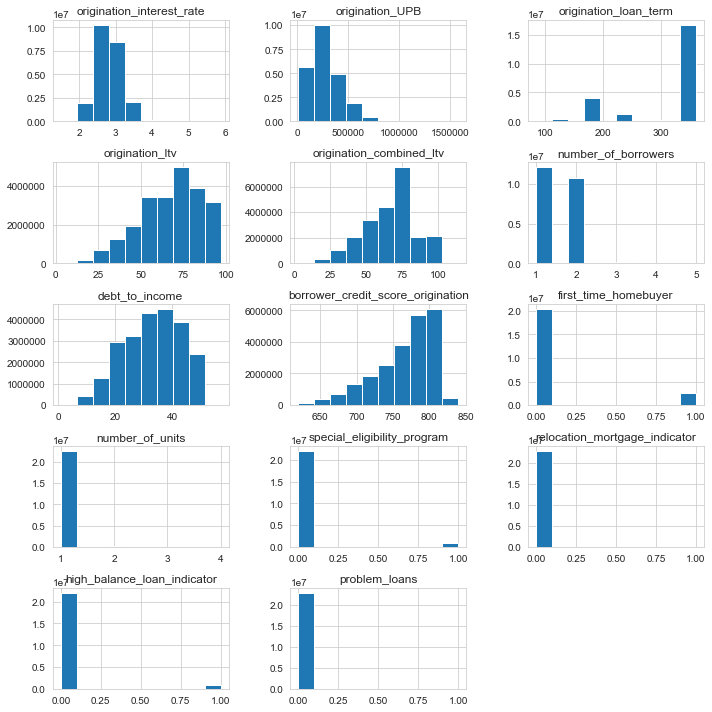

In [55]:
# Create histograms for numerical continuous variables
fig, axes = plt.subplots(nrows = 5, ncols = 3, figsize = (10,10))
fig.set_tight_layout(True)

for index, col in enumerate(numerical_cols.columns):
    ax=axes[index//3][index%3]
    ax.hist(data[col])
    
    axes.flat[-1].set_visible(False) # to remove empty subplot
    
    # Set column name as title
    ax.set_title(col)

In [56]:
# Examine distribution of target variable
print(data['problem_loans'].value_counts())

0    22912691
1       63815
Name: problem_loans, dtype: int64


- Distribution of target variable is highly unbalanced, with less than 1% of observations  
classified as a problem loan. Nonetheless, at over 63k observations, the value count of  
problem loans is large enough to train models in this analysis.

In [57]:
# Examine problem loans according to mean values of numerical continuous variables
data.groupby('problem_loans')[numerical_cols.columns].mean()

,origination_interest_rate,origination_UPB,origination_loan_term,origination_ltv,origination_combined_ltv,number_of_borrowers,debt_to_income,borrower_credit_score_origination,first_time_homebuyer,number_of_units,special_eligibility_program,relocation_mortgage_indicator,high_balance_loan_indicator,problem_loans
problem_loans,,,,,,,,,,,,,,
0,2.786097,282150.659082,314.604481,66.947668,67.226441,1.479667,32.864692,765.910337,0.111871,1.024431,0.039080,0.000973,0.038890,0.0
1,2.958554,314239.442137,342.506809,78.810530,79.203541,1.294570,38.237280,725.325107,0.242106,1.039740,0.075609,0.001128,0.060691,1.0


- As expected, interest rates, unpaid principal balance, LTV, and combined LTV (which accounts for  
original loan amount, home equity line of credit drawn, and outstanding principal balance of any  
other underlying mortgage loan) are higher for problem loans than performing loans
- Also expected, debt-to-income is higher and borrower credit score is lower for problem loans


In [58]:
# Unpaid principal balance at origination difference between problem loans and non-problem loans
print(f'{100*(314239.442137-282150.659082)/282150.6590821}', '%')

11.372925074636376 %


- problem loans are associated with higher interest rates, higher unpaid principal balances, longer loan term,  
months to maturity, loan-to-values, debt-to-income, number of units
    - mean unpaid principal balance is 11% higher for problem loans compared to non-problem loans.
- problem loans are associated with lower number of borrowers and lower credit score

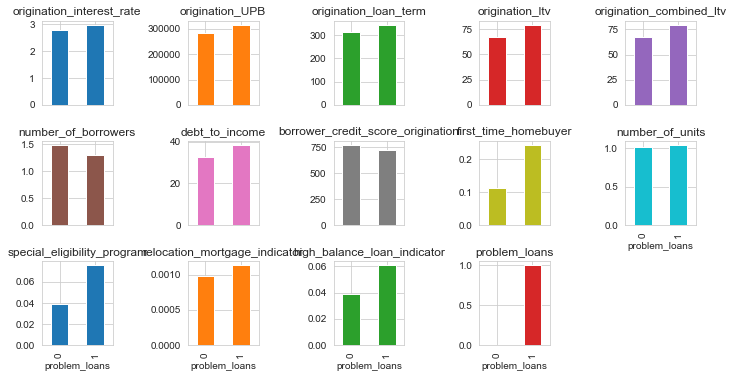

In [59]:
# Plot problem loan classication by mean numerical values
data.groupby('problem_loans')[numerical_cols.columns].mean().plot(kind='bar', 
                                                          subplots=True, 
                                                          layout=(6,5), 
                                                          figsize=(10,10),
                                                          legend=False)
plt.tight_layout()
plt.show()

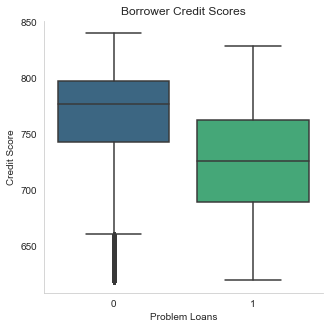

In [60]:
# Boxplot of problem loan classification by borrower credit scores
fig, axes = plt.subplots(figsize=(5,5))
sns.boxplot(x=data['problem_loans'], y=data['borrower_credit_score_origination'],  
                notch= False, palette = 'viridis')

# Set xlabel and ylabels
plt.xlabel('Problem Loans')
plt.ylabel('Credit Score')

# Remove grid lines
plt.grid(False)

# Remove borders
sns.despine()

# Set title
plt.title('Borrower Credit Scores')
plt.show()

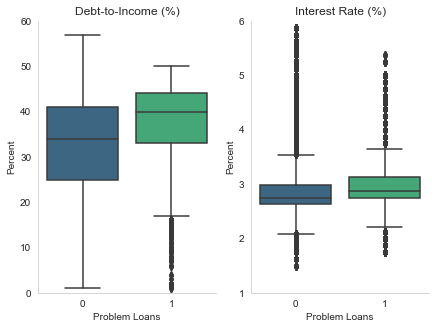

In [61]:
# Boxplot of problem loan classification by debt-to-income and interest rate
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(7,5))

# Plot problem loans classification by debt-to-income
sns.boxplot(x=data['problem_loans'], y=data['debt_to_income'],  
                notch= False, palette = 'viridis', ax = axes[0])

# Set y axis range
axes[0].set_ylim([0, 60])

# Set xlabel and ylabels
axes[0].set(xlabel = 'Problem Loans')
axes[0].set(ylabel = 'Percent')

# Set subplot title
axes[0].set_title('Debt-to-Income (%)')


# Plot problem loans classification by interest rate
sns.boxplot(x=data['problem_loans'], y=data['origination_interest_rate'],  
                notch= False, palette = 'viridis', ax = axes[1])

# Set y axis range
axes[1].set_ylim([1, 6])

# Set xlabel and ylabels
axes[1].set(xlabel='Problem Loans')
axes[1].set(ylabel='Percent')

# Set subplot title
axes[1].set_title('Interest Rate (%)')

# Remove grid lines
axes[0].grid(False)
axes[1].grid(False)

# Remove borders
sns.despine()

# Set title
#plt.title('Interest Rate')
plt.show()

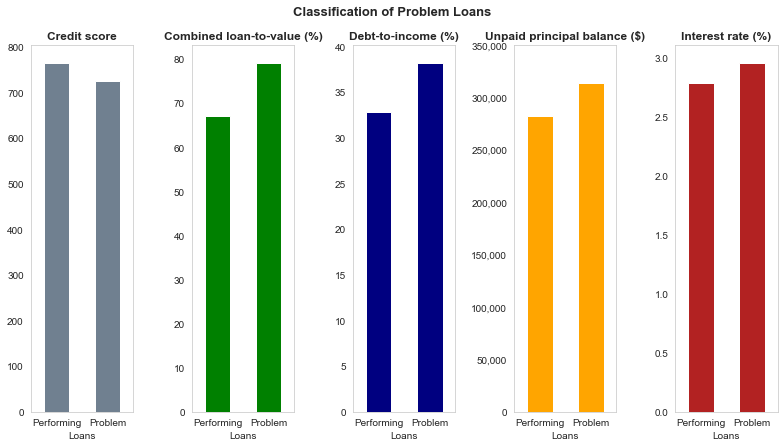

In [62]:
# Plot problem loans by credit score, combined loan-to-value, debt-to-income,
# and unpaid principal balance
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (11,6))
fig.set_tight_layout(True)

data.groupby('problem_loans')['borrower_credit_score_origination'].mean().plot(
kind='bar',  color='slategray', ax=axes[0])

data.groupby('problem_loans')['origination_combined_ltv'].mean().plot(
kind='bar', color='green', ax = axes[1])

data.groupby('problem_loans')['debt_to_income'].mean().plot(
kind='bar', color='navy', ax = axes[2])

data.groupby('problem_loans')['origination_UPB'].mean().plot(
kind='bar', color='orange', ax = axes[3])

data.groupby('problem_loans')['origination_interest_rate'].mean().plot(
kind='bar',  color='firebrick', ax=axes[4])

# Set y-axis ticks range and label
axes[3].set_ylim([0, 350000])
axes[3].yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Format x-tick labels and x-labels
xlabels = ['Performing', 'Problem']
axes[0].set_xticklabels(xlabels, rotation=0)
axes[0].set_xlabel('Loans')
axes[1].set_xticklabels(xlabels, rotation=0)
axes[1].set_xlabel('Loans')
axes[2].set_xticklabels(xlabels, rotation=0)
axes[2].set_xlabel('Loans')
axes[3].set_xticklabels(xlabels, rotation=0)
axes[3].set_xlabel('Loans')
axes[4].set_xticklabels(xlabels, rotation=0)
axes[4].set_xlabel('Loans')

# Format subplot titles
axes[0].set_title('Credit score', fontweight='bold')
axes[1].set_title('Combined loan-to-value (%)', fontweight='bold')
axes[2].set_title('Debt-to-income (%)', fontweight='bold')
axes[3].set_title('Unpaid principal balance ($)', fontweight='bold')
axes[4].set_title('Interest rate (%)', fontweight='bold')

# Remove grid lines
axes[0].grid(False)
axes[1].grid(False)
axes[2].grid(False)
axes[3].grid(False)
axes[4].grid(False)

# Remove borders
#sns.despine(ax=ax)

# Set title
fig.suptitle('Classification of Problem Loans',
             fontsize=13, fontweight='bold', y=1.03)

plt.show()

In [63]:
categorical_cols.columns

Index(['channel', 'seller_name', 'loan_purpose', 'property_type',
       'occupancy_status', 'property_state', 'mortgage_insurance_type'],
      dtype='object')

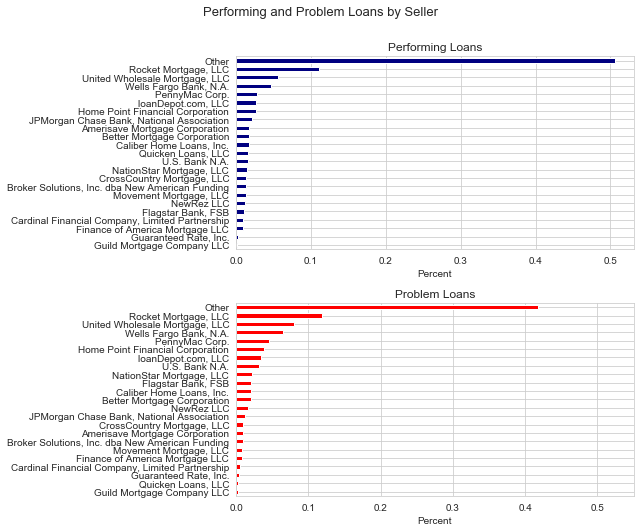

In [64]:
# Plot classification of problem loans by seller

# Create figure and set size
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize= (9,7))

data[(data.problem_loans == 0)]['seller_name'].value_counts(
    normalize=True, ascending=True).plot(kind='barh', color = 'navy', ax=axes[0])
axes[0].set_xlabel('Percent')
axes[0].set_title('Performing Loans')

data[(data.problem_loans == 1)]['seller_name'].value_counts(
    normalize=True, ascending=True).plot(kind='barh', color = 'red', ax=axes[1])
axes[1].set_xlim([0, 0.55])
axes[1].set_xlabel('Percent')
axes[1].set_title('Problem Loans')

# Set title
fig.suptitle('Performing and Problem Loans by Seller',
             fontsize=13, y=1.05)

fig.tight_layout()

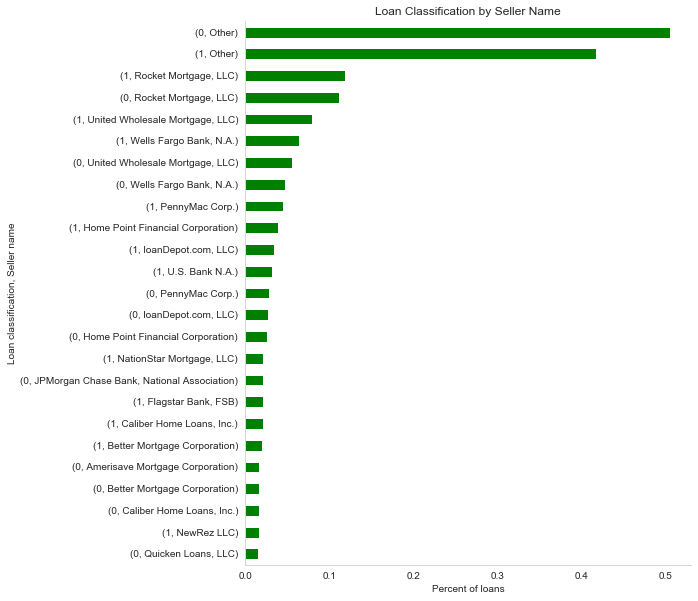

In [65]:
# Plot classification of problem loans by seller

# Create figure and set size
fig, ax = plt.subplots(figsize=(8,10))
data.groupby('problem_loans')['seller_name'].value_counts(
    normalize=True).sort_values().tail(25).plot(kind='barh', color='green', 
                                                ax=ax)
# Set y label
plt.ylabel('Loan classification, Seller name')

# Set x label
plt.xlabel('Percent of loans')

# Remove grid line
plt.grid(False)

# Remove top border and right border
sns.despine()

# Set title
plt.title('Loan Classification by Seller Name')

plt.show()

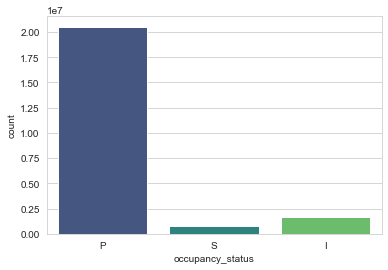

In [66]:
sns.countplot(x='occupancy_status', data=data, palette='viridis')

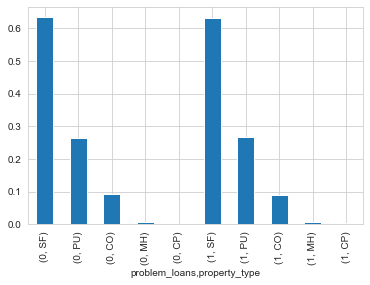

In [67]:
data.groupby('problem_loans')['property_type'].value_counts(normalize=True).plot(kind='bar')

- Majority of performing and problem loans are single-family homes, followed by planned urban developments, and condos. The share of performing and problem loans are roughly equal these property types.

In [68]:
data.groupby('problem_loans')['loan_purpose'].value_counts(normalize=True)

problem_loans  loan_purpose
0              R               0.551703
               P               0.241763
               C               0.206534
1              P               0.436386
               R               0.391131
               C               0.172483
Name: loan_purpose, dtype: float64

- Loans for purchase for higher shares of problem loans than they do for performing loans.

In [69]:
data.groupby('problem_loans')['first_time_homebuyer'].value_counts(normalize=True)

problem_loans  first_time_homebuyer
0              0                       0.888129
               1                       0.111871
1              0                       0.757894
               1                       0.242106
Name: first_time_homebuyer, dtype: float64

- First-time homebuyers account for a larger share of problem loans than they do for performing loans.

In [70]:
data.groupby('problem_loans')['occupancy_status'].value_counts(normalize=True)

problem_loans  occupancy_status
0              P                   0.893324
               I                   0.071385
               S                   0.035291
1              P                   0.927854
               I                   0.054407
               S                   0.017739
Name: occupancy_status, dtype: float64

- Problem loans have higher share of primary home occupancy status than investment or secondary  
home status compared to performing loans.

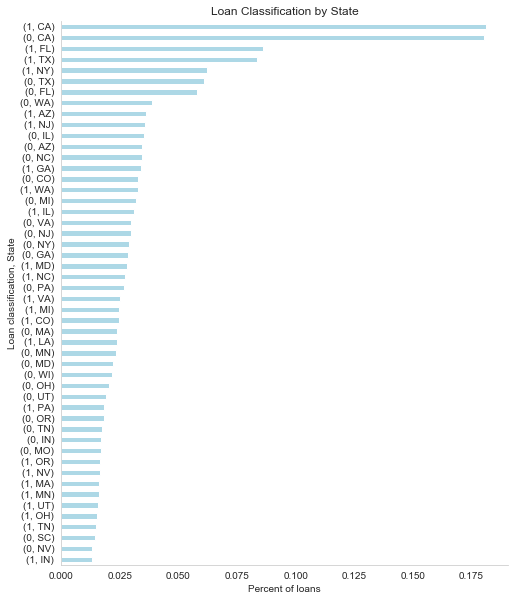

In [71]:
# Plot classification of problem loans by state

# Create figure and set size
fig, ax = plt.subplots(figsize=(8,10))
data.groupby('problem_loans')['property_state'].value_counts(
    normalize=True).sort_values().tail(50).plot(kind='barh', color='lightblue', 
                                                ax=ax)
# Set y label
plt.ylabel('Loan classification, State')

# Set x label
plt.xlabel('Percent of loans')

# Remove grid line
plt.grid(False)

# Remove top border and right border
sns.despine()

# Set title
plt.title('Loan Classification by State')

plt.show()

## Modelling

### Undersampling

To balance distribution of target variable, perform undersampling of majority class.

In [72]:
df.problem_loans.value_counts()

0    22912691
1       63815
Name: problem_loans, dtype: int64

- There are 63,815 instances of problem loans.

In [73]:
# Create new dataframe with problem loans and random equivalent sample of non-problem loans

# Create df with problem loans
df_problem_loans = df.loc[df.problem_loans == 1]

# Create random sample of non-problem loans, equal to size of problem loans df
df_nonproblem_loans = df.loc[df.problem_loans == 0].sample(n=63815)

# Concat df_problem_loans and df_nonproblem_loans into new, balanced df:
df_balanced = pd.concat([df_problem_loans, df_nonproblem_loans], axis=0)

In [74]:
df_balanced.shape

(127630, 21)

In [75]:
df_balanced.problem_loans.value_counts()

1    63815
0    63815
Name: problem_loans, dtype: int64

### Train-test-split

In [76]:
X = df_balanced.drop(['problem_loans'], axis=1)
y = df_balanced['problem_loans']

In [77]:
# Split data into train and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,
                                                random_state=42)

# For model evaluation, split test set into validate and test sets
# 80(train)-10(validate)-10(test) split
X_test,X_validate,y_test,y_validate = train_test_split(X_test,y_test,test_size=.50,
                                                random_state=42)

### Build column transformer for pipeline

In [78]:
# Filter for integer data types
df_balanced.dtypes[df.dtypes == 'int64']

origination_loan_term            int64
origination_ltv                  int64
origination_combined_ltv         int64
number_of_borrowers              int64
first_time_homebuyer             int64
number_of_units                  int64
special_eligibility_program      int64
relocation_mortgage_indicator    int64
high_balance_loan_indicator      int64
problem_loans                    int64
dtype: object

In [79]:
# Filter for float data types
df_balanced.dtypes[df.dtypes == 'float']

origination_interest_rate            float64
origination_UPB                      float64
debt_to_income                       float64
borrower_credit_score_origination    float64
dtype: object

In [80]:
# Filter for object data types
df_balanced.dtypes[df.dtypes == 'object']

channel                    object
seller_name                object
loan_purpose               object
property_type              object
occupancy_status           object
property_state             object
mortgage_insurance_type    object
dtype: object

In [81]:
# Define lists of numeric and categorical features

numeric_features = ['origination_loan_term', 'origination_ltv', 'origination_combined_ltv',
                    'number_of_borrowers', 'first_time_homebuyer',
                    'number_of_units', 'special_eligibility_program',
                    'relocation_mortgage_indicator', 'high_balance_loan_indicator',
                    'origination_interest_rate', 'origination_UPB', 
                    'debt_to_income', 'borrower_credit_score_origination']

categorical_features = ['channel', 'seller_name', 'loan_purpose', 'property_type', 
                        'occupancy_status', 'property_state', 'mortgage_insurance_type']

In [82]:
# Build column transformer for scaling numerical features and one-hot-encoding  
# categorical features

# Instantiate MinMaxScaler and OneHotEncoder
numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Define preprocessor for numeric and categorical data
feature_preprocessor = ColumnTransformer(transformers=
                [('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)])

In [83]:
# Confirm that ColumnTransformer feature_preprocessor worked
# Apply feature_preprocessor to X_train set and print shape
X_train_transformed = feature_preprocessor.fit_transform(X_train)
print(X_train_transformed.shape)

# Create df and examine
X_train_transformed = pd.DataFrame(X_train_transformed)
X_train_transformed

(102104, 107)


,0,1,2,3,4,5,6,7,8,9,...,97,98,99,100,101,102,103,104,105,106
0,1.000000,0.695652,0.615385,0.000000,0.0,0.333333,0.0,0.0,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.695652,0.615385,0.333333,0.0,0.000000,0.0,0.0,0.0,0.242424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.500000,0.442308,0.333333,0.0,0.000000,0.0,0.0,0.0,0.242424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.000000,0.869565,0.769231,0.000000,0.0,0.000000,0.0,0.0,0.0,0.242424,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.000000,1.000000,0.932692,0.000000,1.0,0.000000,0.0,0.0,0.0,0.545455,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102099,0.127273,0.228261,0.201923,0.000000,0.0,0.000000,0.0,0.0,0.0,0.151515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
102100,1.000000,0.793478,0.701923,0.000000,0.0,0.000000,0.0,0.0,0.0,0.515152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
102101,1.000000,0.815217,0.721154,0.000000,0.0,0.000000,0.0,0.0,1.0,0.212121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
102102,1.000000,0.923913,0.817308,0.000000,1.0,0.000000,0.0,0.0,0.0,0.363636,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [84]:
# Extract names of transformed variables
feature_preprocessor.fit_transform(X_train, y_train)
enc_cat_features = feature_preprocessor.named_transformers_[
                                                    'cat'].get_feature_names()
labels = np.concatenate([numeric_features, enc_cat_features])
transformed_df_columns = pd.DataFrame(feature_preprocessor.transform(X_train), columns=labels).columns
transformed_df_columns.tolist()

['origination_loan_term',
 'origination_ltv',
 'origination_combined_ltv',
 'number_of_borrowers',
 'first_time_homebuyer',
 'number_of_units',
 'special_eligibility_program',
 'relocation_mortgage_indicator',
 'high_balance_loan_indicator',
 'origination_interest_rate',
 'origination_UPB',
 'debt_to_income',
 'borrower_credit_score_origination',
 'x0_B',
 'x0_C',
 'x0_R',
 'x1_Amerisave Mortgage Corporation',
 'x1_Better Mortgage Corporation',
 'x1_Broker Solutions, Inc. dba New American Funding',
 'x1_Caliber Home Loans, Inc.',
 'x1_Cardinal Financial Company, Limited Partnership',
 'x1_CrossCountry Mortgage, LLC',
 'x1_Finance of America Mortgage LLC',
 'x1_Flagstar Bank, FSB',
 'x1_Guaranteed Rate, Inc.',
 'x1_Guild Mortgage Company LLC',
 'x1_Home Point Financial Corporation',
 'x1_JPMorgan Chase Bank, National Association',
 'x1_Movement Mortgage, LLC',
 'x1_NationStar Mortgage, LLC',
 'x1_NewRez LLC',
 'x1_Other',
 'x1_PennyMac Corp.',
 'x1_Quicken Loans, LLC',
 'x1_Rocket Mortg

In [85]:
# Check len of new transformed_df_columns
len(transformed_df_columns)

107

In [86]:
# Create list of column names that have been transformed
transformed_col_names = [
    'origination_loan_term', 'origination_ltv', 'origination_combined_ltv',
    'number_of_borrowers', 'first_time_homebuyer', 'number_of_units',
    'special_eligibility_program', 'relocation_mortgage_indicator', 
    'high_balance_loan_indicator', 'origination_interest_rate',
    'origination_UPB', 'debt_to_income', 'borrower_credit_score_origination',  
    'channel_B', 'channel_C', 'channel_R', 
    'seller_Amerisave Mortgage','seller_Better Mortgage',
    'seller_New American Funding','seller_Caliber Home Loans',
    'seller_Cardinal Financial','seller_CrossCountry Mortgage',
    'seller_Finance of America Mortgage','seller_Flagstar Bank',
    'seller_Guaranteed Rate','seller_Guild Mortgage Company',
    'seller_Home Point Financial','seller_JPMorgan Chase Bank',
    'seller_Movement Mortgage','seller_NationStar Mortgage',
    'seller_NewRez','seller_Other','seller_PennyMac','seller_Quicken Loans',
    'seller_Rocket Mortgage','seller_U.S. Bank',
    'seller_United Wholesale Mortgage','seller_Wells Fargo Bank',
    'seller_loanDepot.com','loan_purpose_C', 'loan_purpose_P', 'loan_purpose_R', 
    'property_type_CO', 'property_type_CP', 'property_type_MH', 
    'property_type_PU', 'property_type_SF', 'occupancy_status_I', 
    'occupancy_status_P', 'occupancy_status_S', 
    'state_AK', 'state_AL', 'state_AR', 'state_AZ','state_CA','state_CO',
    'state_CT','state_DC','state_DE','state_FL','state_GA','state_GU',
    'state_HI','state_IA','state_ID','state_IL','state_IN','state_KS',
    'state_KY','state_LA','state_MA','state_MD','state_ME','state_MI',
    'state_MN','state_MO','state_MS','state_MT','state_NC','state_ND',
    'state_NE','state_NH','state_NJ','state_NM','state_NV','state_NY',
    'state_OH','state_OK','state_OR','state_PA','state_PR','state_RI',
    'state_SC','state_SD','state_TN','state_TX','state_UT','state_VA',
    'state_VT','state_WA','state_WI','state_WV','state_WY',
    'mortgage_insurance_type_borrower_paid','mortgage_insurance_type_enterprise_paid', 
    'mortgage_insurance_type_lender_paid', 'mortgage_insurance_type_none'
    ]

In [87]:
# Check len of new list
len(transformed_col_names)

107

In [89]:
# Rename columns
X_train_transformed.columns = transformed_col_names
X_train_transformed

,origination_loan_term,origination_ltv,origination_combined_ltv,number_of_borrowers,first_time_homebuyer,number_of_units,special_eligibility_program,relocation_mortgage_indicator,high_balance_loan_indicator,origination_interest_rate,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,mortgage_insurance_type_borrower_paid,mortgage_insurance_type_enterprise_paid,mortgage_insurance_type_lender_paid,mortgage_insurance_type_none
0,1.000000,0.695652,0.615385,0.000000,0.0,0.333333,0.0,0.0,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.695652,0.615385,0.333333,0.0,0.000000,0.0,0.0,0.0,0.242424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.500000,0.442308,0.333333,0.0,0.000000,0.0,0.0,0.0,0.242424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.000000,0.869565,0.769231,0.000000,0.0,0.000000,0.0,0.0,0.0,0.242424,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.000000,1.000000,0.932692,0.000000,1.0,0.000000,0.0,0.0,0.0,0.545455,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102099,0.127273,0.228261,0.201923,0.000000,0.0,0.000000,0.0,0.0,0.0,0.151515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
102100,1.000000,0.793478,0.701923,0.000000,0.0,0.000000,0.0,0.0,0.0,0.515152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
102101,1.000000,0.815217,0.721154,0.000000,0.0,0.000000,0.0,0.0,1.0,0.212121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
102102,1.000000,0.923913,0.817308,0.000000,1.0,0.000000,0.0,0.0,0.0,0.363636,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Define Function Evaluation Metrics

Evaluation metrics: The lender seeks to correctly i) identify problem loans (true negatives) in order to
minimize  
losses from un-repaid loans and ii) identify good, performing loans (true positives) in
order to maximize profits.

Given the need to minimize false positives and false negatives, the f1-score should be a primary evaluation  
metric. F1-score is interpreted as a harmonic mean of the precision and recall.

Model evaluation should also focus on precision, since there is a need to minimize losses from false positives.

In [199]:
# Define function for model evaluation metrics for validation set
def model_evaluation(model_pipe, X_train, y_train, X_validate, y_validate, 
                     model_name):

    y_pred_train = model_pipe.predict(X_train)
    y_pred_validate = model_pipe.predict(X_validate)

    # Define evaluation metric
    fscore_train = f1_score(y_train, y_pred_train)*100
    fscore_validate = f1_score(y_validate, y_pred_validate)*100
    
    #prec_score_train = precision_score(y_train, y_pred_train)*100
    #prec_score_validate = precision_score(y_validate, y_pred_validate)*100

    # Instantiate figure
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 5))
    # Plot confusion matrix
    plot_confusion_matrix(model_pipe, 
                      X_test, y_validate, 
                      cmap = 'Blues',
                     display_labels= ['Problem Loan', 'Performing Loan'],
                     #values_format= '%0.2f', 
                     normalize='true', ax=ax1
                     )
    ax1.grid(False)
    ax1.set_title(f'Confusion Matrix: {model_name}', y=1.05, fontsize = 13)
    
    # Plot ROC curves for train and test sets
    plot_roc_curve(model_pipe, X_train, y_train, ax=ax2, name ='Train ROC curve')
    plot_roc_curve(model_pipe, X_validate, y_validate, ax=ax2, name ='Test ROC curve' )
    ax2.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    # Add axis labels
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC (Receiver Operating Characteristic) Curve')
    # Display ROC curve 
    plt.show()

    # Define ROC_AUC for test and train 
    #roc_score_train_cv = cross_val_score(estimator=model_pipe, X=X_train, y=y_train, 
    #                                      cv=StratifiedKFold(shuffle=True), 
    #                                      scoring='roc_auc').mean()
    roc_score_train = roc_auc_score(y_train, model_pipe.predict_proba(X_train)[:, 1]) 
    roc_score_validate = roc_auc_score(y_validate, model_pipe.predict_proba(X_validate)[:, 1])
    
    print('----------------------------------------------------------')
    # Classification report 
    print('----------------------------------------------------------')
    print(model_name)
    print('Classification Report: Train')
    print(classification_report(y_train, y_pred_train))
    print('----------------------------------------------------------')
    print('Classification Report: Test')
    print(classification_report(y_validate, y_pred_validate))
    print(f'F1 Score for Train Set: {round(fscore_train, 2)}%')
    print(f'F1 Score for Validation Set: {round(fscore_validate, 2)}%')
    #print(f'Precision Score for Train Set: {round(prec_score_train,2)}%')
    #print(f'Precision Score for Validation Set: {round(prec_score_validate,2)}%')
    #print(f'Mean Cross Validated ROC_AUC Score: {roc_score_train_cv:.2%}')
    print(f'ROC_AUC Score for Train Set: {roc_score_train :.2%}')  
    print(f'ROC_AUC Score for Validation Set: {roc_score_validate :.2%}')   
    print('----------------------------------------------------------')
    print('----------------------------------------------------------')

In [200]:
# Define function for model evaluation metrics for test set
def model_evaluation_test_set(model_pipe, X_train, y_train, X_test, y_test, model_name):

    y_pred_train = model_pipe.predict(X_train)
    y_pred_test = model_pipe.predict(X_test)

    # Define evaluation metric
    fscore_train = f1_score(y_train, y_pred_train)*100
    fscore_test = f1_score(y_test, y_pred_test)*100
    
    #prec_score_train = precision_score(y_train, y_pred_train)*100
    #prec_score_test = precision_score(y_test, y_pred_test)*100

    # Instantiate figure
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 5))
    # Plot confusion matrix
    plot_confusion_matrix(model_pipe, 
                      X_test, y_test, 
                      cmap = 'Blues',
                     display_labels= ['Problem Loan', 'Performing Loan'],
                     #values_format= '%0.2f', 
                     normalize='true', ax=ax1
                     )
    ax1.grid(False)
    ax1.set_title(f'Confusion Matrix: {model_name}', y=1.05, fontsize = 13)
    
    # Plot ROC curves for train and test sets
    plot_roc_curve(model_pipe, X_train, y_train, ax=ax2, name ='Train ROC curve')
    plot_roc_curve(model_pipe, X_test, y_test, ax=ax2, name ='Test ROC curve' )
    ax2.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    # Add axis labels
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC (Receiver Operating Characteristic) Curve')
    # Display ROC curve 
    plt.show()

    # Define ROC_AUC for test and train 
    #roc_score_train_cv = cross_val_score(estimator=model_pipe, X=X_train, y=y_train, 
    #                                      cv=StratifiedKFold(shuffle=True), 
    #                                      scoring='roc_auc').mean()
    roc_score_train = roc_auc_score(y_train, model_pipe.predict_proba(X_train)[:, 1]) 
    roc_score_test = roc_auc_score(y_test, model_pipe.predict_proba(X_test)[:, 1])
    
    print('----------------------------------------------------------')
    # Classification report 
    print('----------------------------------------------------------')
    print(model_name)
    print('Classification Report: Train')
    print(classification_report(y_train, y_pred_train))
    print('----------------------------------------------------------')
    print('Classification Report: Test')
    print(classification_report(y_test, y_pred_test))
    print(f'F1 Score for Train Set: {round(fscore_train, 2)}%')
    print(f'F1 Score for Test Set: {round(fscore_test, 2)}%')
    #print(f'Precision Score for Train Set: {round(prec_score_train,2)}%')
    #print(f'Precision Score for Test Set: {round(prec_score_test,2)}%')
    #print(f'Mean Cross Validated ROC_AUC Score: {roc_score_train_cv:.2%}')
    print(f'ROC_AUC Score for Train Set: {roc_score_train :.2%}')  
    print(f'ROC_AUC Score for Test Set: {roc_score_test :.2%}')   
    print('----------------------------------------------------------')
    print('----------------------------------------------------------')

## Classification Modelling

### Baseline model

In [91]:
# Define baseline Decision Stump Classifier (baseline model 1.0)
# Set random state equal to 42. Set max_depth parameter to 2.

stump_clf = DecisionTreeClassifier(random_state=42, max_depth=2)

# Build DummyClassifier model with preprocessing pipeline
stump_pipe = Pipeline(steps = [ ('preprocess', feature_preprocessor),
                        ('classifier', stump_clf)])

# Fit the DummyClassifier pipeline model to training data
stump_pipe.fit(X_train, y_train)

# Predict y on validate data
y_pred = stump_pipe.predict(X_validate)
                             
print(f'Training Score:', np.round(stump_pipe.score(X_train, y_train),2))
print(f'Testing Score:', np.round(stump_pipe.score(X_validate, y_validate),2))

Training Score: 0.7
Testing Score: 0.7


- Mean accuracy score is 70% for training and test sets. Model is not overfitting, but  
performance can be improved.

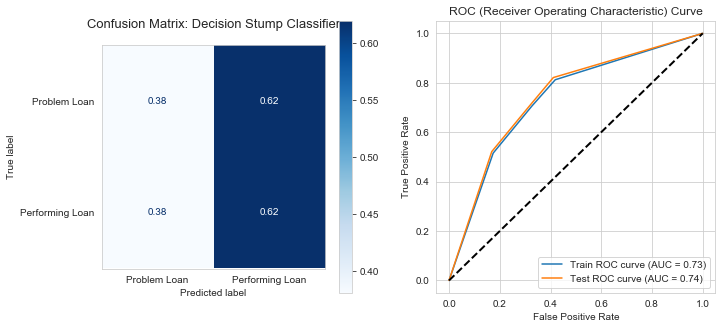

----------------------------------------------------------
----------------------------------------------------------
Decision Stump Classifier
Classification Report: Train
              precision    recall  f1-score   support

           0       0.76      0.58      0.66     51122
           1       0.66      0.81      0.73     50982

    accuracy                           0.70    102104
   macro avg       0.71      0.70      0.69    102104
weighted avg       0.71      0.70      0.69    102104

----------------------------------------------------------
Classification Report: Test
              precision    recall  f1-score   support

           0       0.77      0.59      0.67      6424
           1       0.66      0.82      0.73      6339

    accuracy                           0.70     12763
   macro avg       0.72      0.70      0.70     12763
weighted avg       0.72      0.70      0.70     12763

F1 Score for Train Set: 72.78%
F1 Score for Validation Set: 73.39%
ROC_AUC Score for T

In [201]:
# Evaluate model performance with validation sets
model_evaluation(stump_pipe, X_train, y_train, X_validate, y_validate, 
                 'Decision Stump Classifier')

- Baseline model has f1-score of 73%, precision score of 66%, and ROC-AUC score of 74% for validation set,  
which can be improved in subsequent modelling.   

### Model iterations

#### Decision Tree

In [93]:
# Build decision tree classifier with greater max_depth than decision stump classifier
# Set random state equal to 42.
dt_clf = DecisionTreeClassifier(random_state=42)

# Create pipeline for Decision Tree Classifier
dt_pipe = Pipeline([('preprocessor', feature_preprocessor), 
                   ('dt', dt_clf)])

# Define model hyperparameters for GridSearch in a dictionary                            
dt_param_grid = {
     'dt__criterion': ['entropy','gini'],
     'dt__splitter': ['best', 'random'],
     'dt__max_depth': [4,6,8,10, 12], #lower values avoid overfitting
     'dt__min_samples_leaf': [1,2,4,6,8] #higher values avoid overfitting
      }

# Instantiate GridSearchCV
dt_gs = GridSearchCV(dt_pipe,  #pipeline
                     dt_param_grid, #hyperparameters
                     cv=10, #number of cross-validation folds
                     n_jobs=-1,
                     return_train_score=True
                    )

# Fit model to training data    
dt_gs.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         MinMaxScaler(copy=True,
                                                                                      feature_range=(0,
                                                                                                     1)),
                                                                         ['origination_loan_term',
                                                                 

In [94]:
# View best parameters for Decision Tree
dt_gs.best_params_

{'dt__criterion': 'gini',
 'dt__max_depth': 12,
 'dt__min_samples_leaf': 1,
 'dt__splitter': 'best'}

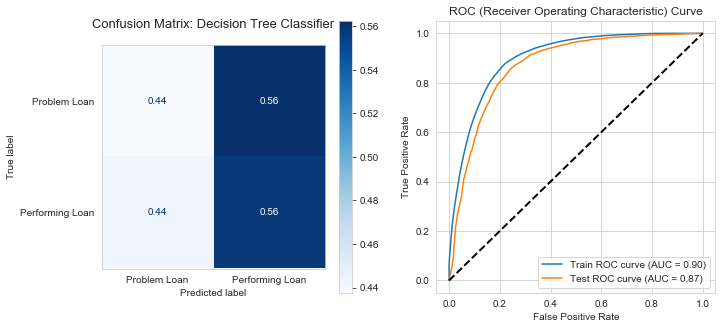

----------------------------------------------------------
----------------------------------------------------------
Decision Tree Classifier
Classification Report: Train
              precision    recall  f1-score   support

           0       0.86      0.78      0.82     51122
           1       0.80      0.87      0.84     50982

    accuracy                           0.83    102104
   macro avg       0.83      0.83      0.83    102104
weighted avg       0.83      0.83      0.83    102104

----------------------------------------------------------
Classification Report: Test
              precision    recall  f1-score   support

           0       0.84      0.76      0.80      6424
           1       0.78      0.86      0.82      6339

    accuracy                           0.81     12763
   macro avg       0.81      0.81      0.81     12763
weighted avg       0.81      0.81      0.81     12763

F1 Score for Train Set: 83.54%
F1 Score for Validation Set: 81.52%
ROC_AUC Score for Tr

In [202]:
# Evaluate decision tree classifier with validation sets
model_evaluation(dt_gs, X_train, y_train, X_validate, y_validate, 
                 'Decision Tree Classifier')

- Decision tree classifier model shows improvement compared to baseline model in f1 score (82%),  
precision score (78%), and ROC-AUC score (87%) for validation set. 
- Model is not overfitting, as train and validation scores are close.

#### Logistic Regression

In [97]:
# Build logistic regression model
# Set random state equal to 42, solver to 'lbfgs'
lr = LogisticRegression(fit_intercept=False,
                               random_state=42,
                               solver='lbfgs',
                               max_iter=1e4)

# Build logistic regression model with preprocessing pipeline
lr_pipe = Pipeline(steps = 
                   [('preprocessor', feature_preprocessor), 
                   ('lr', lr)])

# Fit logistic regression model to training data
lr_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  MinMaxScaler(copy=True,
                                                               feature_range=(0,
                                                                              1)),
                                                  ['origination_loan_term',
                                                   'origination_ltv',
                                                   'origination_combined_ltv',
                                                   'number_of_borrowers',
                                                   'first_time_homebuyer',
                                                   'number_of_units',
                      

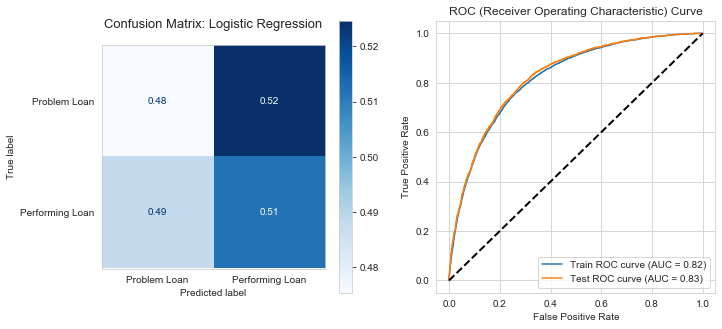

----------------------------------------------------------
----------------------------------------------------------
Logistic Regression
Classification Report: Train
              precision    recall  f1-score   support

           0       0.76      0.73      0.74     51122
           1       0.74      0.76      0.75     50982

    accuracy                           0.75    102104
   macro avg       0.75      0.75      0.75    102104
weighted avg       0.75      0.75      0.75    102104

----------------------------------------------------------
Classification Report: Test
              precision    recall  f1-score   support

           0       0.76      0.73      0.75      6424
           1       0.74      0.77      0.75      6339

    accuracy                           0.75     12763
   macro avg       0.75      0.75      0.75     12763
weighted avg       0.75      0.75      0.75     12763

F1 Score for Train Set: 75.07%
F1 Score for Validation Set: 75.47%
ROC_AUC Score for Train S

In [203]:
# Predict y
y_pred = lr_pipe.predict(X_validate)

# Evaluate logistic regression model with validation sets
model_evaluation(lr_pipe, X_train, y_train, X_validate, y_validate, 
                 'Logistic Regression')

- Logistic regression model also shows improvement compared to baseline model, with  
f1 score of 75%, precision score of 74%, and ROC_AUC score of 83% for validation set.
- Model is not overfitting. Train and validation scores are close.
- With lower f1 score and ROC_AUC score, performance is not as good compared to decision tree  
with grid search.

#### Random Forest

In [100]:
# Instantiate Random Forest classifier model
# Set random_state to 42
rf_clf = RandomForestClassifier(random_state=42)

# Create pipeline
rf_pipe = Pipeline(steps = [('preprocessor', feature_preprocessor), 
                   ('rf', rf_clf)])

# Define hyperparameters for GridSearch in a dictionary 
rf_param_grid = {
    'rf__criterion':['gini','entropy'],
     'rf__max_depth': [4,6,8,10],
     'rf__max_features': ['auto', 'sqrt'],
     'rf__min_samples_leaf': [2,3,4],
     'rf__min_samples_split': [2,4,6],
     }

# Instantiate GridSearchCV
rf_gs = GridSearchCV(rf_pipe, rf_param_grid,
                     cv=10,
                     n_jobs=-1,
                     return_train_score=True
                    )

# Fit the Random Forest classifier model to training data
rf_gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         MinMaxScaler(copy=True,
                                                                                      feature_range=(0,
                                                                                                     1)),
                                                                         ['origination_loan_term',
                                                                 

In [101]:
rf_gs.best_params_

{'rf__criterion': 'gini',
 'rf__max_depth': 10,
 'rf__max_features': 'auto',
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 2}

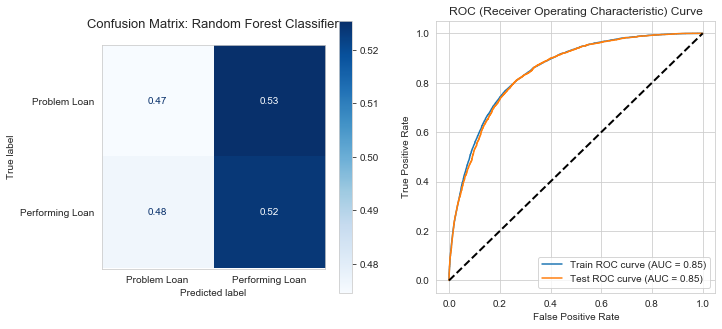

----------------------------------------------------------
----------------------------------------------------------
Random Forest Classifier
Classification Report: Train
              precision    recall  f1-score   support

           0       0.78      0.75      0.77     51122
           1       0.76      0.79      0.78     50982

    accuracy                           0.77    102104
   macro avg       0.77      0.77      0.77    102104
weighted avg       0.77      0.77      0.77    102104

----------------------------------------------------------
Classification Report: Test
              precision    recall  f1-score   support

           0       0.78      0.75      0.77      6424
           1       0.76      0.79      0.77      6339

    accuracy                           0.77     12763
   macro avg       0.77      0.77      0.77     12763
weighted avg       0.77      0.77      0.77     12763

F1 Score for Train Set: 77.59%
F1 Score for Validation Set: 77.4%
ROC_AUC Score for Tra

In [204]:
# Estimate y_pred
y_pred = rf_gs.best_estimator_.predict(X_test)

# Evaluate model performance
model_evaluation(rf_gs.best_estimator_, X_train, y_train, X_validate, y_validate, 
                 'Random Forest Classifier')

- Random Forest model also shows improvement compared to baseline model, with  
f1 score of 77%, precision score of 76%, and ROC_AUC score of 85% for validation set.
- Model is not overfitting. Train and validation scores are close.
- With lower f1 score and ROC-AUC score, performance is not as good compared to decision  
tree with grid search.

#### Gradient Boosting

In [104]:
#Instantiate GradientBoosting Classifier
gb_clf = GradientBoostingClassifier(random_state=42, learning_rate = 0.005)

#Define pipeline
gb_pipe = Pipeline(steps = [('preprocessor', feature_preprocessor), 
                   ('gb', gb_clf)])

# Define hyperparameters for GridSearch in a dictionary 
gb_param_grid = {
     'gb__max_depth': [4,6,8,10,12],
     'gb__min_samples_leaf': [2, 3, 4],
     'gb__min_samples_split': [2,4,6],
     }

# Instantiate GridSearchCV
gb_gs = GridSearchCV(gb_pipe, gb_param_grid,
                     cv=10,
                     n_jobs=-1,
                     return_train_score=True
                    )

# Fit GradientBoosting Model to training data
gb_gs.fit(X_train, y_train)

# Predict y on testing data
y_pred = gb_gs.predict(X_validate)

In [105]:
gb_gs.best_params_

{'gb__max_depth': 12, 'gb__min_samples_leaf': 2, 'gb__min_samples_split': 2}

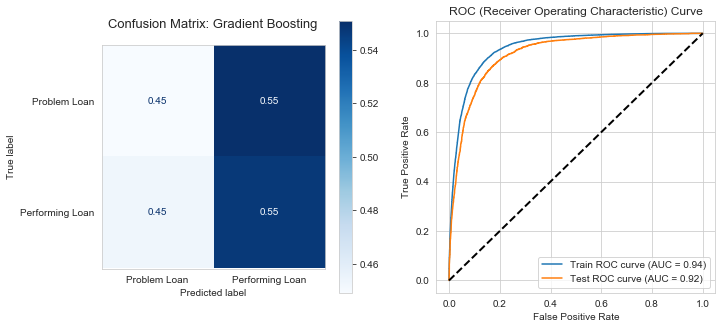

----------------------------------------------------------
----------------------------------------------------------
Gradient Boosting
Classification Report: Train
              precision    recall  f1-score   support

           0       0.90      0.84      0.87     51122
           1       0.85      0.90      0.88     50982

    accuracy                           0.87    102104
   macro avg       0.87      0.87      0.87    102104
weighted avg       0.87      0.87      0.87    102104

----------------------------------------------------------
Classification Report: Test
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      6424
           1       0.82      0.89      0.85      6339

    accuracy                           0.85     12763
   macro avg       0.85      0.85      0.85     12763
weighted avg       0.85      0.85      0.85     12763

F1 Score for Train Set: 87.67%
F1 Score for Validation Set: 85.14%
ROC_AUC Score for Train Set

In [207]:
# Evaluate model performance on validation sets
model_evaluation(gb_gs, X_train, y_train, X_validate, y_validate,
                 'Gradient Boosting')

- Gradient Boosting model also shows improvement compared to baseline model, with  
f1 score of 85%, precision score of 82%, and ROC_AUC score of 92% for validation set.
- Model is not overfitting. Train and validation scores are close.
- Performance is good compared to baseline and decision tree, random forest,  
and logistic regression models.

#### XGBoost Classifier

In [190]:
# Instantiate XGBoost model
xgb_clf = XGBClassifier(random_state=42, learning_rate = 0.005)

# Build pipeline
xgb_pipe = Pipeline(steps = [('preprocessor', feature_preprocessor), 
                   ('xgb', xgb_clf)])

# Defining hyperparameters for GridSearch in a dictionary 
xgb_param_grid = {
     'xgb__max_depth': [4,6,8,10,12],
     'xgb__min_samples_leaf': [2,3,4],
     'xgb__min_samples_split': [2,4,6],
     }

# Instantiate GridSearchCV
xgb_gs = GridSearchCV(xgb_pipe, xgb_param_grid,
                     cv=10,
                     n_jobs=-1,
                     return_train_score=True
                     )

# Fit model
xgb_gs.fit(X_train, y_train)

# Predict y on testing data
y_pred = xgb_gs.predict(X_test)

Training Score: 0.86
Testing Score: 0.83


In [192]:
xgb_gs.best_params_

{'xgb__max_depth': 12, 'xgb__min_samples_leaf': 2, 'xgb__min_samples_split': 2}

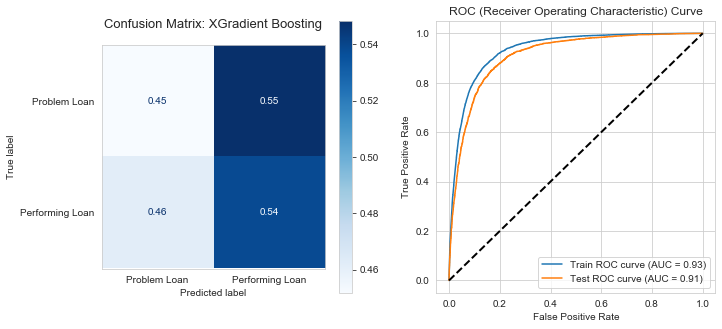

----------------------------------------------------------
----------------------------------------------------------
XGradient Boosting
Classification Report: Train
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     51122
           1       0.84      0.89      0.87     50982

    accuracy                           0.86    102104
   macro avg       0.86      0.86      0.86    102104
weighted avg       0.86      0.86      0.86    102104

----------------------------------------------------------
Classification Report: Test
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      6424
           1       0.82      0.88      0.84      6339

    accuracy                           0.84     12763
   macro avg       0.84      0.84      0.84     12763
weighted avg       0.84      0.84      0.84     12763

F1 Score for Train Set: 86.64%
F1 Score for Validation Set: 84.41%
ROC_AUC Score for Train Se

In [213]:
# Evaluate model performance on validation sets
model_evaluation(xgb_gs, X_train, y_train, X_validate, y_validate,
                 'XGradient Boosting')

- XG Boost model also shows improvement compared to baseline model, with  
f1 score of 84%, precision score of 82%, and ROC_AUC score of 91% for validation set.
- Model does not have a problem with overfitting. Train and validation scores  
are close. 
- XG Boost model is among top performers based on f1 score and ROC_AUC score.

## Model evaluation

- Based on evaluation metrics, the top three models will be evaluated with test set data:  
decision tree, gradient boosting, xgboost 

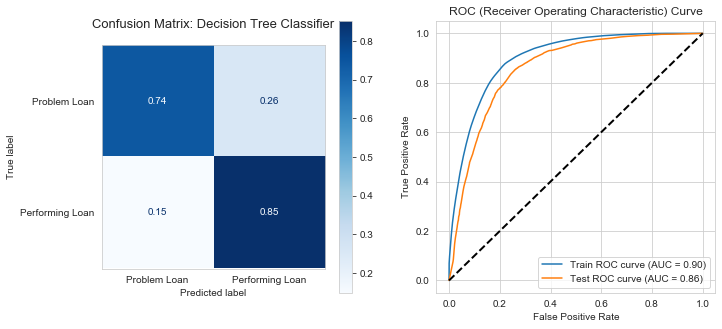

----------------------------------------------------------
----------------------------------------------------------
Decision Tree Classifier
Classification Report: Train
              precision    recall  f1-score   support

           0       0.86      0.78      0.82     51122
           1       0.80      0.87      0.84     50982

    accuracy                           0.83    102104
   macro avg       0.83      0.83      0.83    102104
weighted avg       0.83      0.83      0.83    102104

----------------------------------------------------------
Classification Report: Test
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      6269
           1       0.77      0.85      0.81      6494

    accuracy                           0.80     12763
   macro avg       0.80      0.80      0.80     12763
weighted avg       0.80      0.80      0.80     12763

F1 Score for Train Set: 83.54%
F1 Score for Test Set: 81.05%
ROC_AUC Score for Train Se

In [214]:
# Model evaluation with test sets: Decision tree with grid search.
model_evaluation_test_set(dt_gs, X_train, y_train, X_test, y_test, 
                 'Decision Tree Classifier')

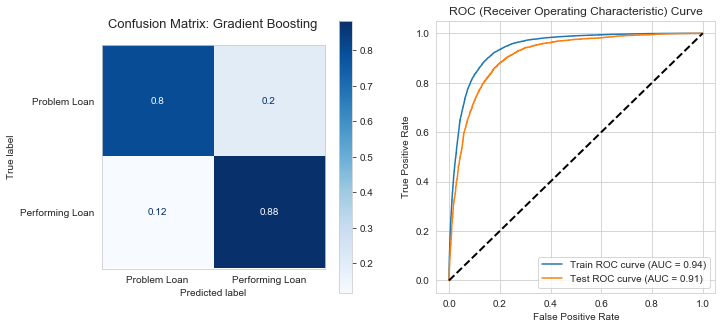

----------------------------------------------------------
----------------------------------------------------------
Gradient Boosting
Classification Report: Train
              precision    recall  f1-score   support

           0       0.90      0.84      0.87     51122
           1       0.85      0.90      0.88     50982

    accuracy                           0.87    102104
   macro avg       0.87      0.87      0.87    102104
weighted avg       0.87      0.87      0.87    102104

----------------------------------------------------------
Classification Report: Test
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      6269
           1       0.82      0.88      0.85      6494

    accuracy                           0.84     12763
   macro avg       0.84      0.84      0.84     12763
weighted avg       0.84      0.84      0.84     12763

F1 Score for Train Set: 87.67%
F1 Score for Test Set: 84.92%
ROC_AUC Score for Train Set: 94.1

In [215]:
# Model evaluation with test set: Gradient boosting with grid search
model_evaluation_test_set(gb_gs, X_train, y_train, X_test, y_test,
                 'Gradient Boosting')

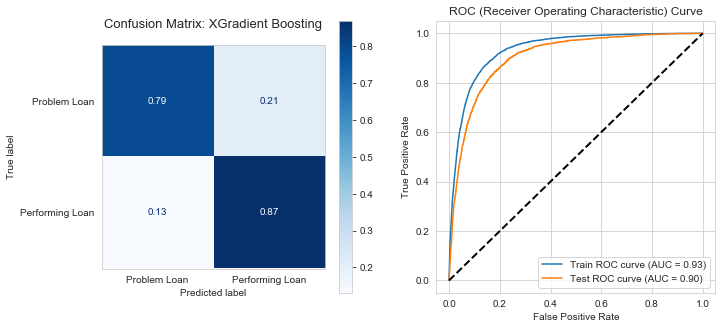

----------------------------------------------------------
----------------------------------------------------------
XGradient Boosting
Classification Report: Train
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     51122
           1       0.84      0.89      0.87     50982

    accuracy                           0.86    102104
   macro avg       0.86      0.86      0.86    102104
weighted avg       0.86      0.86      0.86    102104

----------------------------------------------------------
Classification Report: Test
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      6269
           1       0.81      0.87      0.84      6494

    accuracy                           0.83     12763
   macro avg       0.83      0.83      0.83     12763
weighted avg       0.83      0.83      0.83     12763

F1 Score for Train Set: 86.64%
F1 Score for Test Set: 84.01%
ROC_AUC Score for Train Set: 93.

In [216]:
# Model evaluation with test set: XGradient Boost with grid search
model_evaluation_test_set(xgb_gs, X_train, y_train, X_test, y_test,
                 'XGradient Boosting')

### Model selection
- XG Boost and Gradient Boosting models have best performance as determined by f1 score and  
ROC_AUC score. Both models have comparable performance metrics.
- XG Boost is selected as best model, with f1 score of 84% and ROC_AUC score of 90.5% for  
the test set.

### Feature importance

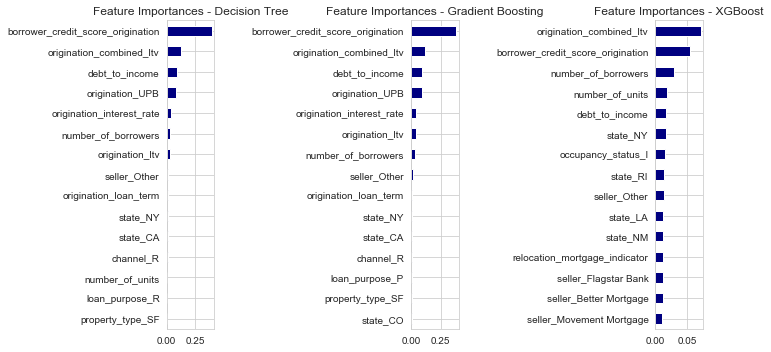

In [218]:
# Plot important features for top 3 models

fig, (ax1,ax2,ax3) = plt.subplots(ncols = 3, figsize=(10,5)) 
    
# Plot decision tree model's feature importance
feature_importance_dt = pd.DataFrame(dt_gs.best_estimator_.named_steps[
                                        'dt'].feature_importances_, 
                                         index=X_train_transformed.columns)
feature_importance_dt.columns = ['importance']
feature_importance_dt.sort_values(by=['importance'], 
                                  ascending=True).tail(15).plot.barh(
                                  color='navy', legend=None, ax=ax1)
ax1.set_title("Feature Importances - Decision Tree")
    
# Plot gradient boosting model's feature importance
feature_importance_gb = pd.DataFrame(gb_gs.best_estimator_.named_steps[
                                        'gb'].feature_importances_, 
                                         index=X_train_transformed.columns)
feature_importance_gb.columns = ['importance']
feature_importance_gb.sort_values(by=['importance'], 
                                  ascending=True).tail(15).plot.barh(
                                  color='navy', legend= None, ax=ax2)
ax2.set_title("Feature Importances - Gradient Boosting")
    
# Plot XGBoost model's feature importance
feature_importance_xgb = pd.DataFrame(xgb_gs.best_estimator_.named_steps[
                                        'xgb'].feature_importances_, 
                                         index=X_train_transformed.columns)
feature_importance_xgb.columns = ['importance']
feature_importance_xgb.sort_values(by=['importance'], 
                                  ascending=True).tail(15).plot.barh(
                                  color='navy', legend = None, ax=ax3)
ax3.set_title("Feature Importances - XGBoost")
    
fig.tight_layout();

- Top three models have similar top features by importance--such as borrower credit scores, loan-to-value,  
debt-to-income, unpaid principal balance, and number of borrowers--although they have varying  
importance scores and relative ranking across the models. This provides confidence in the model results.
- The models also highlight other features that have less relative importance but are significant, such  
as features related to the state the property is located, the seller of the loan, purpose of the loan, and  
occupancy status of the home.

In [235]:
# View important features of selected model: XGBoost
feature_importance_xgb = pd.DataFrame(xgb_gs.best_estimator_.named_steps[
                                        'xgb'].feature_importances_, 
                                         index=X_train_transformed.columns)

In [254]:
feature_importance_xgb.sort_values(by=['importance'], 
                                  ascending=False).head(30)

,importance
origination_combined_ltv,0.071308
borrower_credit_score_origination,0.055146
number_of_borrowers,0.029817
number_of_units,0.018288
debt_to_income,0.016505
state_NY,0.015998
occupancy_status_I,0.015775
state_RI,0.013355
seller_Other,0.013042
state_LA,0.012648


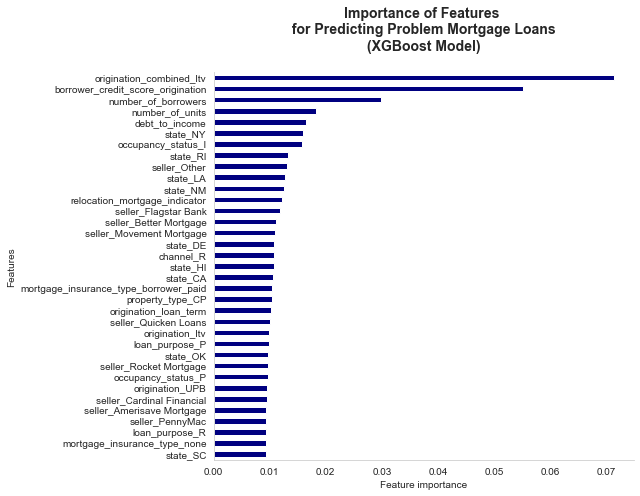

In [251]:
# Plot feature importance of XGBoost model
fig, ax = plt.subplots(figsize=(9,7))

feature_importance_xgb.columns = ['importance']
feature_importance_xgb.sort_values(by=['importance'], 
                                  ascending=True).tail(35).plot.barh(
                                                                color='navy',
                                                                ax=ax)
# Set title and axis labels
ax.set_title('Importance of Features \n for Predicting Problem Mortgage Loans \n (XGBoost Model) \n', 
             fontsize=14, fontweight='bold') 
ax.set_xlabel('Feature importance')
ax.set_ylabel('Features')

# Remove legend
ax.get_legend().remove()

# Remove grid line
plt.grid(False)

# Remove top border and right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

The model identifies combined loan-to-value ratio, borrower credit score, number of borrowers, number of  
units, and debt-to-income ratio as the top five most important features determining whether a loan is classified  
as a problem loan. These findings are not surpring, as these metrics are commonly used in credit risk  
assessments.

Interestingly, the model also identifies several sellers of loans that are important in determining the  
classification of a loan as problematic (such as Flagstar Bank, Better Mortgage, Movement Mortgage, and  
Quicken Loans, Rocket Mortgage, Cardinal Financial, and 'other'). In addition, it also identifies a number  
of states that are important determinants--some of these states are the most populated (such as New York and  
California), but the results also highlight less populated states such as Rhode Island, Louisiana, New Mexico,  
Delaware, Hawaii, and Oklahoma.

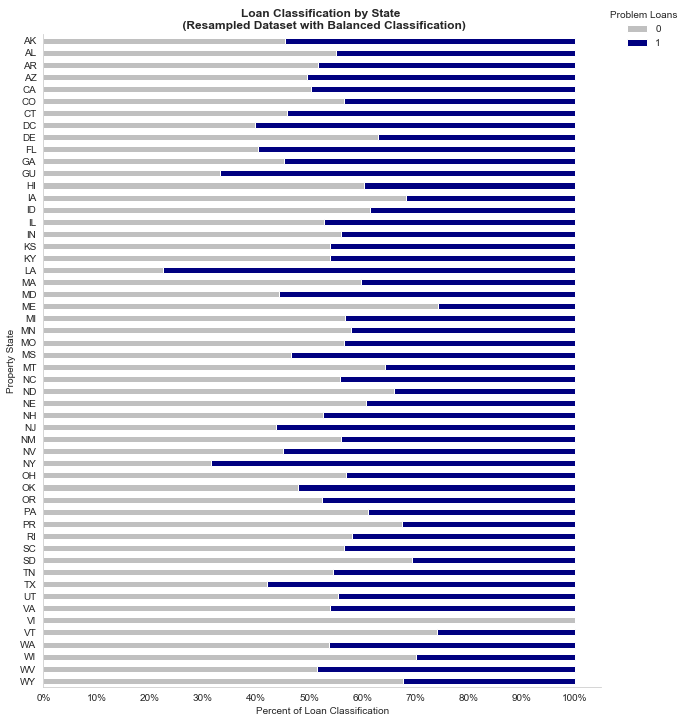

In [640]:
# Plot problem loans classification by state in balanced dataset

df_seller = df_balanced[['property_state', 'problem_loans']]

# Create figure
fig, ax = plt.subplots(figsize=(10,12))
df_seller.groupby(['property_state'])['problem_loans'
                                  ].value_counts(
                                    normalize=True).unstack().plot(
                                    kind='barh', stacked=True, 
                                    color = ['silver', 'navy'], 
                                    ax=ax).invert_yaxis()

# Format x-axis 
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.xaxis.set_ticks(np.arange(0, 1.1, .1))
plt.xlabel('Percent of Loan Classification')

# Format y-axis
plt.ylabel('Property State')

# Format legend
ax.legend(title = 'Problem Loans', frameon=False, loc='right center',
             bbox_to_anchor = (1, 1.05))
# Format plot
ax.grid(False)
# Remove borders
sns.despine(ax=ax)
# Add title
ax.set_title('Loan Classification by State \n (Resampled Dataset with Balanced Classification)', fontweight='bold')
plt.show()

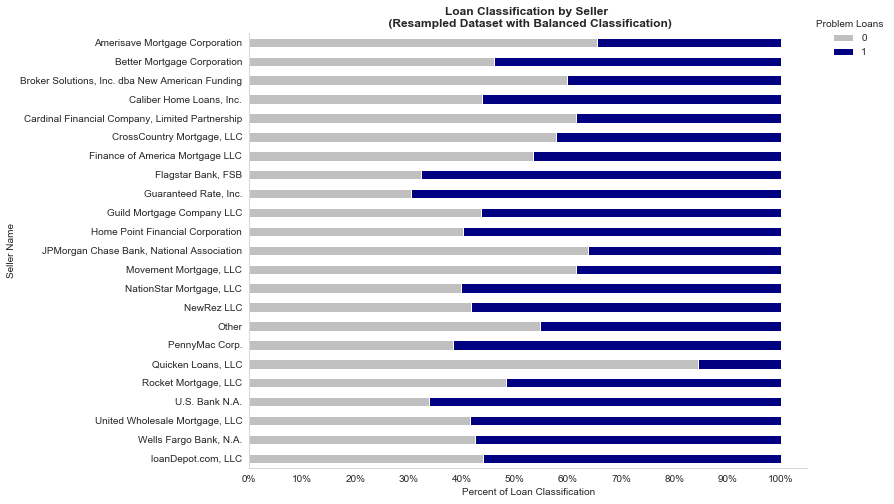

In [639]:
# Plot problem loans classification by seller in balanced dataset

df_seller = df_balanced[['seller_name', 'problem_loans']]

# Create figure
fig, ax = plt.subplots(figsize=(10,8))
df_seller.groupby(['seller_name'])['problem_loans'
                                  ].value_counts(
                                    normalize=True).unstack().plot(
                                    kind='barh', stacked=True, 
                                    color = ['silver', 'navy'], 
                                    ax=ax).invert_yaxis()

# Format x-axis 
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.xaxis.set_ticks(np.arange(0, 1.1, .1))
plt.xlabel('Percent of Loan Classification')

# Format y-axis
plt.ylabel('Seller Name')

# Format legend
ax.legend(title = 'Problem Loans', frameon=False, loc='right center',
             bbox_to_anchor = (1, 1.05))
# Format plot
ax.grid(False)
# Remove borders
sns.despine(ax=ax)
# Add title
ax.set_title('Loan Classification by Seller \n (Resampled Dataset with Balanced Classification)', fontweight='bold')
plt.show()

## Recommendations

Based on results of the best performing model--the XGBoost model--Fannie Mae
should focus credit  
risk management resources, including analysis and loan resolution, on loans that are likely to be problem loans,  
which have on average:
- combined loan-to-value ratio of 79% (compared to 67%)
- borrower credit score of 725 (compared to 766 for performing loans)
- debt-to-income ratios of 38% (compared to 32%)

By location, mortgage loans in the states of Louisiana, New Mexico, and Oklahoma in addition to more populated  
states such as New York and California, should be monitored more closely for problem loans compared to other states.  
Delaware, Hawaii, and Rhode Island also have feature importance, in this case more likely in support of performing  
(non-problem) loans.

By seller, the peformance of mortgage loans sold by Flagstar Bank and Better Mortgage should be examined more  
closely for problem loans compared to other identified sellers. Movement Mortgage, Quicken Loans, Rocket Mortgage,  
Cardinal Financial and 'other' sellers are also signficant, in this case increasing the likelihood of performing (non-problem)  
loans.

## Next Steps

Next steps include broadening the geographical assessment of problem loans by zipcode, as well as predicting the value  
of losses for problem loans.

## TO DO

To do:
- README file
- upload images
- upload df to Kaggle